## ✈️ *TravelTide* - Customer Segmentation Project              
---
### Data Preparation - Session Level

### 1. Introduction
In the previous notebook, the structure, quality, and temporal dynamics of the TravelTide database were established.  
As part of that process, the file **`session_level_raw`** was generated through a SQL query combining all relevant tables via explicit joins.  
This extract includes **all user sessions within the analysis window starting from 2023-01-04**, restricted to **users with more than seven sessions**, and fully aligned with the **trip lifecycle logic**.

In this notebook, we load that session-level dataset and proceed with data cleaning, targeted exploratory analysis, and the first round of feature engineering.  
The final output of this workflow will be a consolidated **user-level dataset**.


**Author**: Maria Petralia  
**Project**: TravelTide - Customer Segmentation & Perk Strategy  
**Context**: MasterSchool - Data Science Program  
**Date**: Feb 2026

### 2. Setup


This section initializes the environment for the session-level analysis, loading core libraries, defining global plotting styles, and preparing the visual identity used throughout the notebook.

###### Load Libraries

In [0]:
# Load Libraries
# ---------------------------------------------

# Data Handling & Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display utilities
from IPython.display import display, HTML


###### Set Global Plotting Style

In [0]:
# Global Plotting Style 
# ---------------------------------------------

# Base seabord style
sns.set(style="ticks") 

# TravelTide visual identity (global palette) 
travel_palette = [
    "#176C8C",  # Blue 1 - mid ocean
    "#7E6A9F",  # Purple 1 - lavender
    "#6BBBD9",  # Blue 3 - light sky
    "#D0F3FF",  # Blue 4 - light blue
    "#E8C9A1",  # Sand 1 - warm sand
    "#F1D7B5",  # Sand 2 - soft beige
    "#F4B998",  # Sand 3 - peach sand
    "#DD1111",  # Red 1 - bright red
]

### 3. Load the Raw Session-Level File

###### Session-Level DataFrame

In [0]:
# Load the session-level CSV exported in Notebook 02
csv_path = "../data/raw/session_level_raw.csv"
sl_df = pd.read_csv(csv_path, low_memory=False)

print("Session-level dataset loaded.")

# Quick check
sl_df.head()


Session-level dataset loaded.


,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,flight_booked,hotel_discount,hotel_discount_amount,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights,rooms,check_in_time,check_out_time,hotel_per_room_usd
0,513347-53b8cae2741a47a38c3a0bd837fc6b06,513347,513347-a0ea4b8b2a6244da92a9bbb66a4e5af9,2023-01-29 18:24:00,2023-01-29 18:27:26.000000,28,True,0.15,True,False,NaN,True,False,1974-10-08,F,True,True,usa,los angeles,LAX,33.942,-118.408,2023-01-06,LAX,edmonton,YEG,1.0,True,2023-02-08 07:00:00,2023-02-11 07:00:00,1.0,Air Canada,53.667,-113.467,378.92,Fairmont - edmonton,2.0,1.0,2023-02-08 11:47:03.930,2023-02-10 11:00:00,129.0
1,514318-f6964894bb014d4190d4eaac6d49122a,514318,514318-48629aa17e58491b8605807a928a92ba,2023-01-29 11:24:00,2023-01-29 11:26:15.000000,18,False,NaN,True,False,NaN,True,False,1971-07-27,F,True,True,usa,seattle,SEA,47.449,-122.309,2023-01-06,SEA,san diego,NZY,1.0,True,2023-02-06 09:00:00,2023-02-08 09:00:00,1.0,American Airlines,32.699,-117.215,311.31,Choice Hotels - san diego,1.0,1.0,2023-02-06 13:07:09.570,2023-02-08 11:00:00,360.0
2,544449-9ec11f30602645c587856aaf234f34bd,544449,544449-9c868af3e36048a09b8158d5e8e2e1cf,2023-01-29 19:50:00,2023-01-29 19:51:58.000000,16,False,NaN,True,False,NaN,True,False,1979-06-17,M,True,True,usa,new york,LGA,40.777,-73.872,2023-01-21,LGA,houston,HOU,1.0,True,2023-02-08 10:00:00,2023-02-10 10:00:00,1.0,Southwest Airlines,29.607,-95.159,385.16,Marriott - houston,1.0,1.0,2023-02-08 14:51:41.400,2023-02-10 11:00:00,151.0
3,557508-c8e532ef18064eba946c78d2dfde7438,557508,557508-c5fe10a144384c99b8476b05b81ad958,2023-01-29 12:41:00,2023-01-29 12:43:58.000000,24,False,NaN,True,True,0.05,True,False,1989-06-26,F,False,False,usa,san jose,SJC,37.362,-121.929,2023-01-28,SJC,washington,IAD,2.0,True,2023-02-03 14:00:00,2023-02-06 14:00:00,1.0,American Airlines,38.852,-77.037,1457.32,Rosewood - washington,1.0,2.0,2023-02-03 20:51:51.255,2023-02-05 11:00:00,102.0
4,559863-83ccf47914b549889033016aa8d81e7b,559863,559863-8d830c0943044feeb019afe6e9d7a5fe,2023-01-29 21:54:00,2023-01-29 21:57:34.000000,29,False,NaN,True,False,NaN,True,False,1990-05-05,F,False,False,usa,indianapolis,IND,39.717,-86.294,2023-01-29,IND,columbus,LCK,3.0,True,2023-02-05 10:00:00,2023-02-09 10:00:00,0.0,Allegiant Air,39.998,-82.892,152.18,Crowne Plaza - columbus,3.0,3.0,2023-02-05 12:21:54.180,2023-02-09 11:00:00,64.0


**Note**: The session-level file generated in Notebook 02 was successfully loaded and converted into a pandas DataFrame.    
The preview of the first five rows confirms that the structure, column names, and data types match the expected schema, ensuring that the dataset is ready for cleaning and exploratory analysis.


### 4. Data Cleaning


This section prepares the session-level dataset for exploratory analysis.  
The cleaning process focuses on:

- validating and converting data types  
- handling structurally expected missing values  
- identifying and correcting timestamp inconsistencies  
- ensuring temporal coherence across hotel, flight, and session data  

As established in Notebook 02, the dataset is already temporally consistent at the **trip lifecycle** level (booking -> cancellation).  
Here we refine the dataset at the **session** level to ensure analytical reliability.  
A dedicated lifecycle validation, including the relationship between booking and cancellation sessions and the behavior of product-level fields, is performed later in Section **4.6**, where the session-trip logic is examined in detail.


#### 4.1 Data Overview

###### Dimensions

In [0]:
# Shape of the dataframe 
sl_df.shape

(49218, 41)

###### Data Type Overview

In [0]:
# Data Type Structure
sl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49218 entries, 0 to 49217
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   session_id               49218 non-null  object 
 1   user_id                  49218 non-null  int64  
 2   trip_id                  16709 non-null  object 
 3   session_start            49218 non-null  object 
 4   session_end              49218 non-null  object 
 5   page_clicks              49218 non-null  int64  
 6   flight_discount          49218 non-null  bool   
 7   flight_discount_amount   8282 non-null   float64
 8   flight_booked            49218 non-null  bool   
 9   hotel_discount           49218 non-null  bool   
 10  hotel_discount_amount    6206 non-null   float64
 11  hotel_booked             49218 non-null  bool   
 12  cancellation             49218 non-null  bool   
 13  birthdate                49218 non-null  object 
 14  gender                

**Note**: The dataset contains 49,218 rows and 41 columns. Several fields require type conversion:

- **Datetime fields stored as object**  
(`session_start`, `session_end`, `birthdate`, `sign_up_date`,
`departure_time`, `return_time`, `check_in_time`, `check_out_time`)

- **Boolean field stored as string**  
(`return_flight_booked`)

Missing values in flight and hotel level fields are structurally expected, since most sessions do not include a booking.

#### 4.2 Missing Values and Duplicates

###### Missing Value Percentages

In [0]:
# null-value inspection: percentage of missing values per column
(sl_df.isna().mean() * 100).sort_values(ascending=False).apply(lambda x: f"{x:.2f}%")

hotel_discount_amount      87.39%
flight_discount_amount     83.17%
return_time                72.25%
destination_airport_lon    70.99%
destination_airport_lat    70.99%
destination                70.99%
destination_airport        70.99%
seats                      70.99%
return_flight_booked       70.99%
departure_time             70.99%
checked_bags               70.99%
trip_airline               70.99%
origin_airport             70.99%
base_fare_usd              70.99%
hotel_name                 70.07%
nights                     70.07%
rooms                      70.07%
check_in_time              70.07%
check_out_time             70.07%
hotel_per_room_usd         70.07%
trip_id                    66.05%
sign_up_date                0.00%
session_id                  0.00%
home_airport_lon            0.00%
user_id                     0.00%
session_start               0.00%
session_end                 0.00%
page_clicks                 0.00%
flight_discount             0.00%
flight_booked 

**Note**: Missing values occur almost exclusively in booking‑related fields, as expected.

###### Duplicates

In [0]:
# Check for duplicate rows
sl_df.duplicated().sum()

np.int64(0)

**Note**: No duplicates were found.

###### Duplicate Rows

In [0]:
# Search for duplicate rows excluding session_id (primary key) 
df_no_session = sl_df.drop(columns=["session_id"])
duplicates = df_no_session[df_no_session.duplicated(keep=False)]
duplicates.shape[0]

0

**Note**: No duplicated rows were found.

#### 4.3 Descriptive Statistics

###### Numeric Summary

In [0]:
# descriptive statistics for numeric columns 
sl_df.describe(include=["number"])

,user_id,page_clicks,flight_discount_amount,hotel_discount_amount,home_airport_lat,home_airport_lon,seats,checked_bags,destination_airport_lat,destination_airport_lon,base_fare_usd,nights,rooms,hotel_per_room_usd
count,49218.000000,49218.000000,8282.000000,6206.000000,49218.000000,49218.000000,14277.000000,14277.000000,14277.000000,14277.000000,14277.000000,14730.000000,14730.000000,14730.000000
mean,545250.017798,17.594193,0.139864,0.112182,38.426853,-94.184130,1.215451,0.593052,38.609380,-88.924333,526.625323,3.672912,1.194569,177.947183
std,64719.312886,21.505716,0.083914,0.062120,6.185797,18.065368,0.585937,0.677648,6.952473,33.151309,819.651204,3.806635,0.499328,118.332434
min,23557.000000,1.000000,0.050000,0.050000,21.316000,-157.927000,1.000000,0.000000,-37.008000,-157.927000,2.410000,-2.000000,1.000000,17.000000
25%,517119.000000,6.000000,0.100000,0.050000,33.818000,-112.383000,1.000000,0.000000,33.942000,-112.383000,200.450000,1.000000,1.000000,99.000000
50%,540306.000000,13.000000,0.100000,0.100000,39.103000,-90.035000,1.000000,1.000000,39.872000,-87.752000,381.830000,2.000000,1.000000,148.000000
75%,573901.750000,22.000000,0.200000,0.150000,42.238000,-79.370000,1.000000,1.000000,42.409000,-75.241000,600.980000,5.000000,1.000000,222.000000
max,844489.000000,566.000000,0.600000,0.450000,61.251000,-63.499000,8.000000,8.000000,55.972000,174.792000,21548.040000,43.000000,4.000000,1376.000000


**Note**:
Two issues require attention:
- **Nights** contains impossible values (-2)
- **Page_clicks** shows extreme outliers (566)

All other numeric fields fall within plausible ranges.

#### 4.4 Object Columns - Unique Values

###### Unique Counts

In [0]:
# object-type inspection: unique values per object column 
sl_df.select_dtypes(include="object").nunique().sort_values()

return_flight_booked        2
home_country                2
gender                      3
home_city                 105
destination               125
home_airport              159
origin_airport            159
trip_airline              175
destination_airport       183
sign_up_date              258
check_out_time            371
hotel_name                957
departure_time           2447
return_time              2460
birthdate                4807
check_in_time           12118
trip_id                 16099
session_start           42495
session_end             49129
session_id              49218
dtype: int64

**Note**: Only date-like and boolean-like fields require conversion.  
Identifiers (`session_id`, `trip_id`) remain as strings.

#### 4.5 Data Type Conversion

###### Date Formatting

All datetime fields are converted using pd.to_datetime().  
Values are already clean (as confirmed in Notebook 02), so no parsing logic is required.

In [0]:
# Convert all date columns from object to pandas datetime
sl_df["session_start"] = pd.to_datetime(sl_df["session_start"])
sl_df["session_end"] = pd.to_datetime(sl_df["session_end"], format="mixed")
sl_df["birthdate"] = pd.to_datetime(sl_df["birthdate"])
sl_df["sign_up_date"] = pd.to_datetime(sl_df["sign_up_date"])
sl_df["departure_time"] = pd.to_datetime(sl_df["departure_time"])
sl_df["return_time"] = pd.to_datetime(sl_df["return_time"])
sl_df["check_in_time"] = pd.to_datetime(sl_df["check_in_time"], format="mixed")
sl_df["check_out_time"] = pd.to_datetime(sl_df["check_out_time"])


**Note**: `return_flight_booked` is intentionally not converted yet, because it contains three semantically distinct states (`True`, `False`, `None`).
Transformation will occur after session types are finalized.

###### Data Type Checks

In [0]:
sl_df.dtypes

session_id                         object
user_id                             int64
trip_id                            object
session_start              datetime64[ns]
session_end                datetime64[ns]
page_clicks                         int64
flight_discount                      bool
flight_discount_amount            float64
flight_booked                        bool
hotel_discount                       bool
hotel_discount_amount             float64
hotel_booked                         bool
cancellation                         bool
birthdate                  datetime64[ns]
gender                             object
married                              bool
has_children                         bool
home_country                       object
home_city                          object
home_airport                       object
home_airport_lat                  float64
home_airport_lon                  float64
sign_up_date               datetime64[ns]
origin_airport                    

**Note**: Data types are now consistent.

#### 4.6 Session and Trip Lifecycle Semantics

In Notebook 02, the session-trip lifecycle logic was validated directly on the original TravelTide database through SQL control queries.   

In the dataset under analysis, **a trip is created by exactly one booking session**, identified by a non-null `trip_id` and `cancellation = False`.

If a trip is later cancelled, **exactly one additional session is generated**, with:

- the same `trip_id`

- `cancellation = True`

As a result, **cancelled trips appear as a 1:1 pair of booking session + cancellation session**, while non-cancelled trips appear as a single booking session only.

This lifecycle assumption is **specific to the TravelTide dataset under analysis** and is not a generic property of booking systems.

It was explicitly verified through control queries on the full database and holds for all trips included in the analysis window.

###### Cross-Tab Session Behavior

In [0]:
# Make a copy of the dataframe
df_logic = sl_df.copy()

# Add boolean columns to indicate presence of bookings and cancellations
df_logic["flight_data_present"] = df_logic["base_fare_usd"].notnull()
df_logic["hotel_data_present"] = df_logic["hotel_per_room_usd"].notnull()
df_logic["trip_present"] = df_logic["trip_id"].notnull()


In [0]:
# Build a full cross-tab of all possible cancellation/booking/data combinations
cases = (
    df_logic
    .groupby([
        "cancellation",
        "flight_booked",
        "hotel_booked",
        "flight_data_present",
        "hotel_data_present",
        "trip_present"
    ])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

In [0]:
# Add a column to interpret the booking/cancellation patterns
def interpret_session(row):
    if not row["trip_present"]:
        return "Browsing session"
    
    if row["cancellation"] == False:
        if row["flight_booked"] and row["hotel_booked"]:
            return "Booking: Flight + Hotel"
        elif row["flight_booked"] and not row["hotel_booked"]:
            return "Booking: Flight only"
        elif row["hotel_booked"] and not row["flight_booked"]:
            return "Booking: Hotel only"
        else:
            return "Booking: Unknown pattern"
    
    else:
        # cancellation session
        # session-level flags are always True, but product presence depends on trip structure
        if row["flight_data_present"] and row["hotel_data_present"]:
            return "Cancellation: Flight + Hotel"
        elif row["flight_data_present"] and not row["hotel_data_present"]:
            return "Cancellation: Flight only"
        elif row["hotel_data_present"] and not row["flight_data_present"]:
            return "Cancellation: Hotel only"
        else:
            return "Cancellation: Unknown pattern"

cases["interpretation"] = cases.apply(interpret_session, axis=1)
cases

,cancellation,flight_booked,hotel_booked,flight_data_present,hotel_data_present,trip_present,count,interpretation
0,False,False,False,False,False,False,32509,Browsing session
3,False,True,True,True,True,True,11931,Booking: Flight + Hotel
1,False,False,True,False,True,True,2382,Booking: Hotel only
2,False,True,False,True,False,True,1786,Booking: Flight only
6,True,True,True,True,True,True,367,Cancellation: Flight + Hotel
5,True,True,True,True,False,True,193,Cancellation: Flight only
4,True,True,True,False,True,True,50,Cancellation: Hotel only


Each row of this table represents one valid session type observed in the dataset.  
The interpretation column summarizes the corresponding lifecycle stage:

- **Browsing** -> no `trip_id`, no booking or product data
- **Booking** -> `cancellation = False`, `trip_id` present, product data aligned with booking flags
- **Cancellation** -> `cancellation = True`, `trip_id` present, booking flags are set to `True`, product data inherited from the original booking.

All observed combinations follow the expected lifecycle:
**browsing -> booking -> optional cancellation**.

**Note**: This cross-tab is used to **validate how the TravelTide system encodes user behavior across sessions and trips**.  
It is not a data quality check and no cleaning or correction is applied here.

Each row represents one observed combination of:

- booking flags
- product-level data presence
- cancellation status
- trip identifier availability

The table makes the session-trip lifecycle explicit and shows that all combinations follow a coherent internal logic.

**Observed session types**

- **Browsing sessions**
  - No `trip_id`
  - All booking flags set to `False`
  - No product-level data present    
These sessions represent pure exploration activity.

- **Booking sessions** (**`cancellation = False`**)
  - Always contain a trip_id
  - Booking flags correctly reflect the booked products
  - Product-level data is present only for booked components

  Specifically:
  - Hotel-only bookings -> `hotel_booked = True`, `hotel_data_present = True`
  - Flight-only bookings -> `flight_booked = True`, `flight_data_present = True`
  - Combined bookings -> all booking flags and product data present

- **Cancellation sessions** (**`cancellation = True`**)
    - Always contain a valid trip_id
    - Product-level data is present only for the products originally booked
    - Booking flags are set to `True`
    - These sessions are logged separately from the booking session that created the trip

The distribution of counts across combinations confirms a consistent lifecycle:

**browsing -> booking (hotel/flight/both) -> optional cancellation**

This check ensures that the lifecycle classification and booking logic used later in the EDA are **grounded in the actual system behavior**, not in assumptions about how cancellations should work.

#### 4.7 Nights Analysis and Booking Consistency

The `nights` variable is a key component of the hotel booking data.  
It represents the number of nights stayed and is expected to be consistent with the hotel check-in and check-out timestamps.  
However, the initial inspection revealed several anomalies that required a deeper investigation.

This section performs a systematic validation of hotel stay information, identifies structural inconsistencies, and applies data-driven corrections.
The analysis also uncovers important behavioral patterns related to partial cancellations of hotel or flight components.


##### 4.7.1 Initial Inspection

In [0]:
# Check: nights — inspecting raw values before conversion 
sl_df["nights"].unique()

array([ 2.,  1.,  3.,  7.,  0., -1.,  4.,  6.,  8.,  5., nan, 12., 19.,
       10.,  9., 11., 16., 13., 14., 17., 15., 21., 22., 20., 31., 24.,
       18., 27., 34., 25., 42., 28., 23., 32., 35., 40., 26., 29., 33.,
       30., -2., 43.])

**Note**: The first inspection of the `nights` column revealed unexpected values:

- negative values (`-1`, `-2`)
- zero-night stays
- missing values (`NaN`)

Negative nights are logically impossible and indicate deeper issues in the hotel timestamp data. Zero-night stays may be valid (same-day check-in/out), but they also frequently co-occur with timestamp inconsistencies.

These findings motivated a full validation of hotel stay durations.


In [0]:
# Check the only negative values
sl_df[sl_df["nights"] < 0]

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,flight_booked,hotel_discount,hotel_discount_amount,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights,rooms,check_in_time,check_out_time,hotel_per_room_usd
11,562886-e766db8902c048e09c94ad41f68359e2,562886,562886-56c06ef71df34257ad92c4af48227fd8,2023-01-30 10:40:00,2023-01-30 10:42:31.000000,20,False,NaN,True,False,NaN,True,False,1977-03-16,F,True,False,usa,san francisco,SFO,37.619,-122.375,2023-01-30,SFO,los angeles,LAX,1.0,True,2023-02-05 10:00:00,2023-02-06 10:00:00,1.0,Cathay Pacific,33.942,-118.408,109.34,Aman Resorts - los angeles,-1.0,1.0,2023-02-05 12:40:44.535,2023-02-05 11:00:00,127.0
38,468808-6955c60ecd43457cad66db559b0ee350,468808,468808-5ec867ed59f54959bfcbfedae11800e8,2023-02-03 04:14:00,2023-02-03 04:16:59.000000,24,False,NaN,True,False,NaN,True,False,1978-06-13,F,False,True,canada,windsor,YQG,42.276,-82.956,2022-12-14,YQG,jacksonville,NIP,1.0,True,2023-02-08 07:00:00,2023-02-09 07:00:00,1.0,American Airlines,30.494,-81.688,228.29,Starwood - jacksonville,-1.0,1.0,2023-02-08 10:38:37.320,2023-02-07 11:00:00,67.0
61,552172-4114233cd1ff4648b6e5ee4d80271a1a,552172,552172-6ba14984ffbe4573bd7c4dd589e0570b,2023-02-05 19:28:00,2023-02-05 19:32:22.000000,36,False,NaN,True,False,NaN,True,False,1969-12-06,F,True,True,usa,las vegas,LSV,36.236,-115.034,2023-01-25,LSV,new york,LGA,1.0,True,2023-02-12 16:00:00,2023-02-14 16:00:00,0.0,AirTran Airways,40.640,-73.779,644.11,Accor - new york,-1.0,1.0,2023-02-12 22:29:29.535,2023-02-12 11:00:00,149.0
452,512283-20a4943af12947929bb46ffc0e4c3c6f,512283,512283-d71ba1e8d4ec4535980ececff34fc8aa,2023-04-06 18:01:00,2023-04-06 18:05:02.000000,33,False,NaN,True,False,NaN,True,False,1977-10-11,F,False,False,canada,montreal,YMX,45.680,-74.039,2023-01-05,YMX,tucson,TUS,1.0,True,2023-04-11 07:00:00,2023-04-13 07:00:00,1.0,Alaska Airlines,32.166,-110.883,636.86,Radisson - tucson,-1.0,1.0,2023-04-11 13:21:16.740,2023-04-11 11:00:00,173.0
501,665593-4d204867802b4c85b0c57e21475eda2e,665593,665593-52f866c96fcf4946937591de59c56a26,2023-04-28 00:41:27,2023-04-28 01:21:02.503519,39,True,NaN,True,True,NaN,True,True,1979-08-11,F,True,False,usa,st. louis,STL,38.748,-90.360,2023-03-15,STL,phoenix,LUF,1.0,True,2023-05-10 13:00:00,2023-05-12 13:00:00,1.0,United Airlines,33.535,-112.383,355.00,Crowne Plaza - phoenix,-1.0,1.0,2023-05-10 17:34:07.455,2023-05-10 11:00:00,110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48204,590473-386c96460cdb4be0b6476d313b68911c,590473,590473-a691ec51a9684e359b2069ebe03bc18b,2023-02-12 16:06:00,2023-02-12 16:09:30.000000,28,False,NaN,True,False,NaN,True,False,1976-03-05,F,True,False,usa,new york,LGA,40.777,-73.872,2023-02-12,LGA,fresno,FAT,1.0,True,2023-02-25 12:00:00,2023-02-27 12:00:00,0.0,Alaska Airlines,36.776,-119.718,786.01,Choice Hotels - fresno,-1.0,1.0,2023-02-25 18:56:32.325,2023-02-25 11:00:00,78.0
48309,521335-715797deeb87477796e0e5dce85ffaec,521335,521335-3cce682f216b42a1a8778811b89cd5c9,2023-02-28 17:06:00,2023-02-28 17:10:06.000000,33,False,NaN,True,False,NaN,True,False,1990-05-09,F,False,False,usa,denver,DEN,39.858,-104.667,2023-01-10,DEN,oklahoma city,TIK,1.0,True,2023-03-11 07:00:00,2023-03-12 07:00:00,0.0,Ryanair,35.393,-97.601,138.04,Extended Stay - oklahoma city,-1.0,1.0,2023-03-11 09:59:40.290,2023-03-10 11:00:00,421.0
48391,525804-01ae39cfe033461b84f51d643f26bf46,525804,525804-0cbeb8a6944540819e6c6658c2aa9a6e,2023-03-15 17:10:00,2023-03-15 17:12:58.000000,24,False,NaN,True,False,NaN,True,False,1975-03-18,F,False,True,usa,new york

**Note**: The inspection reveals 107 sessions with negative values (-1, -2) in the `nights` column. A negative number of nights is logically impossible and indicates inconsistencies in the hotel stay data. 

These anomalies suggest that the issue may originate from incorrect or inverted check-in and check-out timestamps. Before applying any correction, a cross-check with flight dates and hotel timestamps is required to understand the pattern and determine the most reliable source of truth.

In [0]:
# Check the negative values and 0 values
sl_df[sl_df["nights"] <= 0]

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,flight_booked,hotel_discount,hotel_discount_amount,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights,rooms,check_in_time,check_out_time,hotel_per_room_usd
9,522152-22127fca4f3542a59128d4dde970b912,522152,522152-4010dde203ff4adf8be7458e89c4f499,2023-01-30 11:38:00,2023-01-30 11:41:00,24,False,NaN,True,False,NaN,True,False,1992-09-27,F,False,True,usa,dallas,DAL,32.847,-96.852,2023-01-10,DAL,los angeles,LSQ,1.0,True,2023-02-04 12:00:00,2023-02-06 12:00:00,1.0,Delta Air Lines,33.942,-118.408,381.11,Rosewood - los angeles,0.0,1.0,2023-02-04 16:30:05.490,2023-02-05 11:00:00,59.0
11,562886-e766db8902c048e09c94ad41f68359e2,562886,562886-56c06ef71df34257ad92c4af48227fd8,2023-01-30 10:40:00,2023-01-30 10:42:31,20,False,NaN,True,False,NaN,True,False,1977-03-16,F,True,False,usa,san francisco,SFO,37.619,-122.375,2023-01-30,SFO,los angeles,LAX,1.0,True,2023-02-05 10:00:00,2023-02-06 10:00:00,1.0,Cathay Pacific,33.942,-118.408,109.34,Aman Resorts - los angeles,-1.0,1.0,2023-02-05 12:40:44.535,2023-02-05 11:00:00,127.0
27,533497-9e80cbf9c7fa407eb3e7278f4ad0bdf7,533497,533497-92485dfc718448839a484916ff763ff3,2023-02-01 08:33:00,2023-02-01 08:36:45,30,False,NaN,True,False,NaN,True,False,1987-11-28,F,False,False,usa,madison,MSN,43.140,-89.337,2023-01-16,MSN,new york,LGA,1.0,True,2023-02-07 12:00:00,2023-02-09 12:00:00,0.0,Allegiant Air,40.640,-73.779,199.54,Choice Hotels - new york,0.0,1.0,2023-02-07 15:38:39.435,2023-02-08 11:00:00,226.0
38,468808-6955c60ecd43457cad66db559b0ee350,468808,468808-5ec867ed59f54959bfcbfedae11800e8,2023-02-03 04:14:00,2023-02-03 04:16:59,24,False,NaN,True,False,NaN,True,False,1978-06-13,F,False,True,canada,windsor,YQG,42.276,-82.956,2022-12-14,YQG,jacksonville,NIP,1.0,True,2023-02-08 07:00:00,2023-02-09 07:00:00,1.0,American Airlines,30.494,-81.688,228.29,Starwood - jacksonville,-1.0,1.0,2023-02-08 10:38:37.320,2023-02-07 11:00:00,67.0
50,523717-9e052184a7b240f883ab5e588f865156,523717,523717-86bf861e051442629e1af21d77d56985,2023-02-04 10:50:00,2023-02-04 10:52:26,19,True,0.1,True,False,NaN,True,False,1982-09-22,F,False,False,usa,baltimore,BWI,39.175,-76.668,2023-01-11,BWI,los angeles,LSQ,1.0,True,2023-02-12 16:00:00,2023-02-15 16:00:00,0.0,Delta Air Lines,33.942,-118.408,651.55,Accor - los angeles,0.0,1.0,2023-02-12 22:40:29.820,2023-02-13 11:00:00,279.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48978,550426-6c6095cbb8dc4452b1632fef95c49155,550426,550426-a85305aa89e54b4cbc77b5e2cef519d5,2023-01-24 22:37:00,2023-01-24 22:39:14,18,True,0.2,True,True,0.05,True,False,1974-08-01,F,True,True,canada,windsor,YQG,42.276,-82.956,2023-01-24,YQG,toronto,YTZ,1.0,True,2023-02-01 09:00:00,2023-02-02 09:00:00,0.0,Porter Airlines,43.862,-79.370,60.47,Conrad - toronto,0.0,1.0,2023-02-01 11:25:32.115,2023-02-01 11:00:00,342.0
48986,516418-d9a96daf3eae4f8f9ebd937e94a54e15,516418,516418-28d410f370fa4f33a2ce45aac412e328,2023-01-25 19:23:00,2023-01-25 19:26:23,27,False,NaN,True,False,NaN,True,False,1997-01-26,F,True,False,usa,dallas,DAL,32.847,-96.852,2023-01-07,DAL,charlotte,CLT,1.0,True,2023-02-01 08:00:00,2023-02-02 08:00:00,1.0,American Airlines,35.214,-80.943,254.60,InterContinental - charlotte,0.0,1.0,2023-02-01 11:51:35.010,2023-02-01 11:00:00,97.0
48993,519596-17a35ba36f374f91b69a418cf6070dc7,519596,519596-b46babd3e2384bc5ae77078506d46b82,2023-01-26 07:46:00,2023-01-26 07:48:48,23,False,NaN,True,False,NaN,True,False,1983-04-15,F,True,True,usa,fayetteville,POB,35.171,-79.014,2023-01-09,POB,san antonio,SAT,1.

**Note**: Extending the analysis to include zero-night stays, the total number of sessions with nights <= 0 rises to 1,335.

Zero-night stays may represent same-day check-in/check-out, but they also frequently co-occur with timestamp inconsistencies.

Many of these anomalies appear alongside inverted or inconsistent hotel timestamps, where check_out_time < check_in_time or where the date difference does not match the recorded number of nights.

##### 4.7.2 Timestamp Validation

To understand the source of the anomalies, hotel timestamps were validated by
checking whether `check_out_time` occurred earlier than `check_in_time`.

In [0]:
# cross-check: check-out earlier than check-in 
checkout_before_checkin = sl_df["check_out_time"] < sl_df["check_in_time"] 
checkout_before_checkin.sum()

np.int64(231)

**Note**: The cross-check between hotel timestamps reveals **231 sessions** where the check-out timestamp was earlier than check-in. 

Such cases are chronologically impossible and indicate corrupted hotel data. 

This number is significantly higher than the 107 sessions with negative nights, confirming that the issue originates from timestamp inconsistencies rather than from the `nights` field itself.
Further validation against flight dates is required to determine the most reliable temporal reference before applying any correction.

##### 4.7.3 Cross-Checking with Flight Dates

In [0]:
# To determine the most reliable temporal reference, hotel timestamps were compared with flight timestamps.
# Check: check-out earlier than check-in
bad = sl_df["check_out_time"] < sl_df["check_in_time"]

# cross-check with flights
(
    sl_df.loc[bad, "check_out_time"] < sl_df.loc[bad, "departure_time"]
).sum(), (
    sl_df.loc[bad, "check_out_time"] > sl_df.loc[bad, "return_time"]
).sum()


(np.int64(59), np.int64(0))

**Note**: The cross-check between hotel check-out timestamps and flight dates reveals a clear temporal inconsistency:

- **59 sessions** have a hotel check-out time earlier than the arrival flight (`departure_time`), which is chronologically impossible.
- **0 sessions** have a check-out time later than the return flight (`return_time`), indicating that the anomaly never shifts forward in time.

This pattern shows that the issue is **systematic and unidirectional**:  the check-out timestamp is frequently recorded **too early**, sometimes even before the guest arrives at the destination.

Combined with the **231 sessions** where check-out occurs before check-in, this strongly suggests a structural problem in the dataset specifically affecting hotel check-out timestamps.



##### 4.7.4 Anomaly Classification

In [0]:
# Detecting and Summarizing Stay Duration Anomalies

# Filter problematic records: nights <= 0
df_bad = sl_df[sl_df["nights"] <= 0].copy()

# Compute date-based nights (hotel logic)
df_bad["nights_by_dates"] = (
    df_bad["check_out_time"].dt.normalize() - df_bad["check_in_time"].dt.normalize()
).dt.days

# Classify anomalies using simple date logic
def classify_simple(row):
    ci = row["check_in_time"]
    co = row["check_out_time"]
    
    # Missing timestamps
    if pd.isna(ci) or pd.isna(co):
        return "missing_timestamps"
    
    # --- TIMESTAMP INVERSION ---
    # Case A: different dates
    if co.date() < ci.date():
        return "timestamp_inversion"
    
    # Case B: same date but time inverted
    if co.date() == ci.date() and co.time() < ci.time():
        return "timestamp_inversion"
    
    # --- INCORRECT NIGHTS ---
    if row["nights_by_dates"] >= 1 and row["nights"] <= 0:
        return "incorrect_nights_value"
    
    # --- SAME DAY STAY ---
    if row["nights_by_dates"] == 0 and row["nights"] == 0:
        return "same_day_stay"
    
    return "other"


df_bad["anomaly_type"] = df_bad.apply(classify_simple, axis=1)

# Summary table
summary = (df_bad["anomaly_type"].value_counts().rename_axis("anomaly_type").reset_index(name="count"))
summary["pct"] = (summary["count"] / len(df_bad)).round(2)

summary


,anomaly_type,count,pct
0,incorrect_nights_value,896,0.67
1,timestamp_inversion,231,0.17
2,same_day_stay,208,0.16


**Note**: Three anomaly types emerge:

- incorrect_nights_value (896 sessions) -> fixable
- timestamp_inversion (231 sessions) -> remove
- same_day_stay (208 sessions) -> valid

##### 4.7.5 Diagnostic Crosstab

In [0]:
# Diagnostic crosstab: anomaly_type × hotel_booked × flight_booked × cancellation

# Select only the relevant columns
cols = ["anomaly_type", "hotel_booked", "flight_booked", "cancellation"]

df_diag = df_bad[cols].copy()

# Build a multi-dimensional crosstab
diagnostic_table = pd.crosstab(
    index=[df_diag["anomaly_type"]],
    columns=[df_diag["hotel_booked"], df_diag["flight_booked"], df_diag["cancellation"]],
    dropna=False
)

diagnostic_table


hotel_booked            True      
flight_booked           True      
cancellation           False True 
anomaly_type                      
incorrect_nights_value   883    13
same_day_stay            204     4
timestamp_inversion      226     5

**Note**: Cross-checking anomaly types against booking signals (`hotel_booked`,`flight_booked`, `cancellation`) reveals clear and consistent patterns:

- **incorrect_nights_value (896 cases)**  
  These sessions almost always involve both a hotel and a flight booking.  
  The timestamps are valid, and the issue lies solely in the under-reported `nights` value. These records should be **corrected**, not removed.

- **same_day_stay (208 cases)**  
  These sessions are also associated with real bookings.  
  They represent legitimate same-day check-in and check-out behavior and should be **retained** without modification.

- **timestamp_inversion (231 cases)**  
  These sessions typically involve both hotel and flight bookings, meaning the timestamps should have been trustworthy.  
  Instead, the check-out time occurs before check-in, indicating **true data
  corruption**. These records must be **excluded** from the analytical dataset.

This diagnostic confirms that the cleaning strategy, correcting under-reported nights, retaining valid same-day stays, and removing timestamp inversions, is both justified and data-driven.


##### 4.7.6 Trip-Level and User-Level Integrity Checks Before and After Removing Invalid Sessions

This subsection validates that removing sessions affected by hotel timestamp inversion does not compromise trip-level lifecycle integrity or reduce user-level coverage.  
The goal is to ensure that cleaning decisions preserve the analytical value of the dataset.

###### Trip-Level Lifecycle Check (Before Removal)

The analysis begins by verifying whether sessions affected by `timestamp_inversion` belong to trips that also appear in valid sessions.  
If a corrupted session were associated with a trip that includes valid sessions, removing it could disrupt the booking-cancellation lifecycle.

In [0]:
# Sessions affected by timestamp inversion
invalid_sessions = df_bad.loc[df_bad["anomaly_type"] == "timestamp_inversion", "session_id"]

# Trip IDs associated with invalid sessions
invalid_trip_ids = sl_df.loc[
    sl_df["session_id"].isin(invalid_sessions), "trip_id"
].unique()

# Check whether these trip IDs appear in any valid session
valid_trip_overlap = sl_df["trip_id"].isin(invalid_trip_ids).sum()
valid_trip_overlap

np.int64(231)

**Note**: All trips associated with timestamp inversion are **entirely corrupted**:

-  Some contain a **booking + cancellation pair**, both inheriting the same corrupted hotel timestamps.
- The remaining ones contain **only corrupted booking sessions**.
- **No valid session** exists for these trip IDs.

This confirms that removing these sessions does **not** break any valid booking-cancellation lifecycle.

###### User-Level Coverage Check (Before Removal)

In [0]:
# Users involved in invalid sessions
invalid_user_ids = (
    sl_df.loc[sl_df["session_id"].isin(invalid_sessions), "user_id"]
    .unique()
)

n_invalid_users = len(invalid_user_ids)
n_total_users = sl_df["user_id"].nunique()
share_invalid_users = n_invalid_users / n_total_users * 100

n_invalid_users, n_total_users, share_invalid_users


(221, 5998, 3.684561520506836)

**Note**: Only a small portion of the user base is affected by corrupted hotel timestamps.

###### Remove  Invalid Sessions

In [0]:
# Invalid_sessions contains the session_id of invalid sessions with timestamp inversions
print(f"Invalid sessions: {len(invalid_sessions)}")

# Remove them using boolean filtering 
sl_df_clean = sl_df[~sl_df["session_id"].isin(invalid_sessions)].copy()
sl_df_clean = sl_df_clean.reset_index(drop=True)

print(f"Original size: {len(sl_df)}")
print(f"Cleaned size:  {len(sl_df_clean)}")
print(f"Removed:       {len(sl_df) - len(sl_df_clean)}")


Invalid sessions: 231
Original size: 49218
Cleaned size:  48987
Removed:       231


**Note**: The **231 sessions** classified as `timestamp_inversion` were removed from the dataset.  
These records cannot be corrected because the temporal sequence is invalid and contradicts both hotel and flight logic.

This step ensures that the remaining dataset is chronologically coherent.


###### User-Level Coverage Check (After Removal)

In [0]:
sl_df_clean["user_id"].nunique()

5998

In [0]:
# Count valid sessions remaining for affected users
valid_sessions_by_user = (
    sl_df_clean[sl_df_clean["user_id"].isin(invalid_user_ids)]
    .groupby("user_id")["session_id"]
    .count()
)

valid_sessions_by_user.describe()

count    221.000000
mean       7.176471
std        0.539855
min        5.000000
25%        7.000000
50%        7.000000
75%        7.000000
max        9.000000
Name: session_id, dtype: float64

**Note**: Every affected user (221 from 5998) retains **at least 5 valid sessions**, with a very stable distribution centered at **7 sessions**.

This means:
- No user is removed from the dataset.
- No user becomes under-represented.
- Behavioral richness is preserved.
- User-level features remain reliable.

Removing the 231 sessions affected by timestamp inversion does not eliminate any users from the dataset.  
All 221 affected users retain between 5 and 9 valid sessions (median = 7, mode = 7), ensuring that user-level coverage and behavioral representativeness remain intact.

Furthermore, all corrupted sessions belong to trips that are entirely invalid: none of their `trip_id` values appear in valid sessions.  
This guarantees that no booking-cancellation lifecycle is broken by the cleaning process.

Overall, removing these corrupted sessions improves temporal consistency without compromising analytical integrity.

##### 4.7.7 Correcting Under-Reported Nights (896 sessions)

In [0]:
# Correct Nights Values for Sessions with Anomalies
# 1. Identify incorrect_nights_value rows in df_bad
incorrect = df_bad["anomaly_type"] == "incorrect_nights_value"

# 2. Extract session_ids of the 896 incorrect nights
incorrect_ids = df_bad.loc[incorrect, "session_id"]

# 3. Update nights in sl_df_clean using nights_by_dates from df_bad
sl_df_clean.loc[sl_df_clean["session_id"].isin(incorrect_ids), "nights"] = df_bad.loc[incorrect, "nights_by_dates"].values

print(f"Corrected nights for {len(incorrect_ids)} sessions.")

Corrected nights for 896 sessions.


**Note**: The **896 sessions** classified as `incorrect_nights_value` had valid hotel
timestamps but an incorrect number of recorded nights.  
Using the date-based stay duration (`nights_by_dates`), the `nights` field was
updated for all affected sessions.

This correction ensures that the dataset reflects accurate and hotel-consistent
stay durations while preserving all sessions with valid temporal information.


##### 4.7.8 Nights and Date-Based Duration Check

In [0]:
# Count sessions where nights exceed hotel stay duration
# 1. Compute date-based nights 
nights_by_dates_clean = (
    sl_df_clean["check_out_time"].dt.normalize()
    - sl_df_clean["check_in_time"].dt.normalize()
).dt.days

# 2. Compare recorded nights vs date-based nights
nights_match_duration = sl_df_clean["nights"] == nights_by_dates_clean
nights_less_than_duration = sl_df_clean["nights"] < nights_by_dates_clean
nights_greater_than_duration = sl_df_clean["nights"] > nights_by_dates_clean

# 3. Build summary table
summary = pd.DataFrame({
    "category": [
        "nights_match_duration",
        "nights_less_than_duration",
        "nights_greater_than_duration"
    ],
    "count": [
        nights_match_duration.sum(),
        nights_less_than_duration.sum(),
        nights_greater_than_duration.sum()
    ]
})

summary


,category,count
0,nights_match_duration,6625
1,nights_less_than_duration,7874
2,nights_greater_than_duration,0


**Note**: Before correcting the nights column, the comparison between the recorded number of nights and the date‑based calculation showed three groups:

- **6,625 sessions** where the recorded nights exactly matched the date-based duration.

- **7,874 sessions** where the recorded nights were lower than the duration implied by check‑in and check‑out dates. These represent valid hotel stays with under-reported nights.

- **0 sessions** where the recorded nights exceeded the date-based duration.

This diagnostic confirmes that the dataset contained a large block of systematically underestimated hotel nights, all of which required correction.

##### 4.7.9 Sample of Under-Reported Nights

In [0]:
# Filter only the sessions where nights < true_nights_clean
less_than_df = sl_df_clean[nights_less_than_duration].copy()

# Add the column nights_by_dates is available
less_than_df["nights_by_dates"] = (
    less_than_df["check_out_time"].dt.normalize()
    - less_than_df["check_in_time"].dt.normalize()
).dt.days

# Select only the most relevant columns
cols_to_show = [
    "session_id",
    "hotel_name",
    "check_in_time",
    "check_out_time",
    "nights",
    "nights_by_dates",
    "rooms",
    "hotel_booked",
    "flight_booked",
    "cancellation"
]

# display the first 10 rows
less_than_df[cols_to_show].head(10)


,session_id,hotel_name,check_in_time,check_out_time,nights,nights_by_dates,rooms,hotel_booked,flight_booked,cancellation
1,514318-f6964894bb014d4190d4eaac6d49122a,Choice Hotels - san diego,2023-02-06 13:07:09.570,2023-02-08 11:00:00,1.0,2,1.0,True,True,False
2,544449-9ec11f30602645c587856aaf234f34bd,Marriott - houston,2023-02-08 14:51:41.400,2023-02-10 11:00:00,1.0,2,1.0,True,True,False
3,557508-c8e532ef18064eba946c78d2dfde7438,Rosewood - washington,2023-02-03 20:51:51.255,2023-02-05 11:00:00,1.0,2,2.0,True,True,False
4,559863-83ccf47914b549889033016aa8d81e7b,Crowne Plaza - columbus,2023-02-05 12:21:54.180,2023-02-09 11:00:00,3.0,4,3.0,True,True,False
7,454430-4266ff6a04584e42abae40e094277b6e,Wyndham - los angeles,2023-02-05 14:10:34.590,2023-02-09 11:00:00,3.0,4,3.0,True,True,False
8,519726-203e293679c24da5824c7d96185cdd09,Conrad - new york,2023-02-04 14:29:44.520,2023-02-06 11:00:00,1.0,2,1.0,True,True,False
10,562108-fa5decc7d29d41649a391f87f1263e99,InterContinental - new york,2023-02-05 15:28:04.890,2023-02-07 11:00:00,1.0,2,1.0,True,True,False
12,514682-8df42c90654f4082bcdaf5e7d159b91d,Hyatt - new york,2023-02-08 18:29:04.920,2023-02-11 11:00:00,2.0,3,1.0,True,True,False
14,525769-2fecd00866d2465fbf3a5338c9798170,Accor - toronto,2023-02-08 17:12:49.365,2023-02-13 11:00:00,4.0,5,1.0,True,True,False
15,546307-14376b7d95f340e2b97481dbf60ca49d,Shangri-La - quebec,2023-02-04 16:26:58.335,2023-02-09 11:00:00,4.0,5,1.0,True,True,False


**Note**: The sample rows below clearly illustrate the issue detected during validation:
for each session, the recorded number of nights (`nights`) is lower than the number of nights implied by the check-in and check-out dates.

For example: 
- A stay from 2023-07-07 to 2023-07-10 spans **3 nights**, but the dataset recorded only **2**.
- A stay from 2023-07-09 to 2023-07-11 spans **2 nights**, but the dataset recorded **1**.
- A stay from 2023-07-09 to 2023-07-14 spans **5 nights**, but the dataset recorded **4**.

All displayed rows follow the same pattern: the date-based calculation is correct, while the stored nights value is systematically underestimated.

This confirms that the **7,874 sessions** flagged as nights_less_than_duration were indeed affected by incorrect night counts and required correction.

##### 4.7.10 Correcting Under-Reported Nights

In [0]:
# 1. Compute the correct number of nights based on calendar dates only
nights_by_dates_clean = (sl_df_clean["check_out_time"].dt.normalize() - sl_df_clean["check_in_time"].dt.normalize()).dt.days

# 2. Identify the records where the recorded nights are lower than the correct value
mask_to_fix = sl_df_clean["nights"] < nights_by_dates_clean

# 3. Update the nights column with the correct values
sl_df_clean.loc[mask_to_fix, "nights"] = nights_by_dates_clean[mask_to_fix]

# 4. Recompute the validation summary after the correction
nights_match_duration = sl_df_clean["nights"] == nights_by_dates_clean
nights_less_than_duration = sl_df_clean["nights"] < nights_by_dates_clean
nights_greater_than_duration = sl_df_clean["nights"] > nights_by_dates_clean


**Note**: The largest anomaly group consisted of **7,874 sessions** where the recorded number of nights was lower than the duration implied by the check-in and check-out dates.

Since the timestamps were valid and consistent with flight dates, the correct number of nights was computed using calendar logic and applied to the dataset.

This correction ensures that hotel stay durations reflect true business logic.


##### 4.7.11 Post-Correction Validation

In [0]:
# Create a dataFrame with the result of the correction
summary_after = pd.DataFrame({
    "category": [
        "nights_match_duration",
        "nights_less_than_duration",
        "nights_greater_than_duration"
    ],
    "count": [
        nights_match_duration.sum(),
        nights_less_than_duration.sum(),
        nights_greater_than_duration.sum()
    ]
})

summary_after

,category,count
0,nights_match_duration,14499
1,nights_less_than_duration,0
2,nights_greater_than_duration,0


**Note**: After applying the corrections:
- **14,499 sessions** now have a perfect match between recorded nights and
  date-based duration.
- **0 sessions** remain with underestimated nights.
- **0 sessions** exceed the date-based duration.

This confirms that all inconsistencies in the `nights` field have been resolved.


In [0]:
# Summary Statistics for Nights Stayed
sl_df_clean["nights"].describe()

count    14499.000000
mean         4.343748
std          3.686732
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         43.000000
Name: nights, dtype: float64

In [0]:
# Display Dimensions of Cleaned DataFrame for Analysis
sl_df_clean.shape

(48987, 41)

##### 4.7.12 Flight Timestamp Consistency Check

In [0]:
# cross-check: return flight earlier than departure flight
return_before_departure = sl_df_clean["return_time"] < sl_df_clean["departure_time"]
return_before_departure.sum()


np.int64(0)

**Note**: The cross-check between `departure_time` and `return_time` shows **0 sessions** where the return flight occurs earlier than the departure flight. This confirms that the flight timestamps are internally consistent and do not exhibit temporal inversions. 

Given that hotel check-out timestamps show significant inconsistencies, the flight dates appear to be the most reliable temporal reference in the dataset. This validation step is essential before reconstructing hotel stay durations or correcting the `nights` variable.

##### 4.7.13 Additional Temporal Consisteny Checks

In [0]:
# Count Sessions Where Nights Exceed Trip Duration
# compute the flight date difference (return minus departure)
flight_diff = (sl_df_clean["return_time"] - sl_df_clean["departure_time"]).dt.days

# identify sessions where nights exceeds the total trip duration
nights_gt_flight = sl_df_clean.loc[nights_match_duration, "nights"] > flight_diff.loc[nights_match_duration]

# count how many such cases exist
nights_gt_flight.sum()



np.int64(0)

**Note**: The comparison between `nights` and the total trip duration defined by `departure_time` and `return_time` shows **0 sessions** where the number of nights exceeds the overall length of the trip.  
This indicates that `nights` never surpasses the maximum possible duration of the journey.  

The flight timestamps therefore provide a consistent upper bound for the stay 
duration and can be considered a reliable temporal reference.


#### 4.8 Categorical Consistency

In [0]:
# Assess unique values in categorical columns
string_cols = [
    "gender", "home_country", "home_city", "home_airport",
    "origin_airport", "destination", "destination_airport",
    "trip_airline", "hotel_name"
]

for col in string_cols:
    print(f"\n--- {col} ---")
    print("Unique values:", sl_df_clean[col].nunique())
    print(sl_df_clean[col].value_counts().head(10))



--- gender ---
Unique values: 3
gender
F    43288
M     5609
O       90
Name: count, dtype: int64

--- home_country ---
Unique values: 2
home_country
usa       40790
canada     8197
Name: count, dtype: int64

--- home_city ---
Unique values: 105
home_city
new york       5536
los angeles    2655
toronto        1838
chicago        1586
houston        1521
montreal       1350
san antonio    1067
phoenix         975
dallas          959
san diego       917
Name: count, dtype: int64

--- home_airport ---
Unique values: 159
home_airport
LGA    2951
LAX    2655
JFK    2585
DAL     959
YYC     817
SFO     648
AUS     638
SJC     612
YOW     608
BNA     603
Name: count, dtype: int64

--- origin_airport ---
Unique values: 159
origin_airport
LGA    872
JFK    828
LAX    760
DAL    282
YYC    240
BNA    204
SJC    198
IND    198
AUS    197
SFO    189
Name: count, dtype: int64

--- destination ---
Unique values: 125
destination
new york        1963
los angeles     1029
toronto          744
chicago 

**Note**: A review of all categorical variables shows that the dataset is already highly consistent. Cities, countries, airports, and airlines follow uniform formatting rules, with no semantic duplicates or capitalization inconsistencies.   
The only minor issue concerns the `hotel_name` field, where some entries contain multiple consecutive spaces. A light normalization step is applied to collapse these into a single space, without altering the meaning or structure of the hotel identifiers.

##### 4.8.1 hotel_name

In [0]:
sl_df_clean["hotel_name"].value_counts().head(10)

hotel_name
Conrad  - new york              123
Best Western - new york         120
Four Seasons - new york         113
Accor - new york                112
Aman Resorts - new york         111
Radisson  - new york            110
Wyndham - new york              109
Fairmont - new york             108
Hilton - new york               107
InterContinental  - new york    107
Name: count, dtype: int64

In [0]:
# Standardize hotel_name formatting and remove extra spaces
sl_df_clean["hotel_name"] = ( sl_df_clean["hotel_name"] .str.replace(r"\s+", " ", regex=True) .str.strip() )

In [0]:
sl_df_clean["hotel_name"].value_counts().head(10)

hotel_name
Conrad - new york              123
Best Western - new york        120
Four Seasons - new york        113
Accor - new york               112
Aman Resorts - new york        111
Radisson - new york            110
Wyndham - new york             109
Fairmont - new york            108
Hilton - new york              107
InterContinental - new york    107
Name: count, dtype: int64

### 5. Exploratory Data analysis (Session-Level)


#### 5.1 Dataset Sanity Checks and Overview

###### Sanity Checks

In [0]:
# Primary Key uniqueness
dup_sessions = sl_df_clean["session_id"].duplicated().sum()

if dup_sessions > 0:
    display(sl_df_clean[sl_df_clean["session_id"].duplicated(keep=False)])

# Browsing logic (trip_id is null -> no booking flags)
browsing_mask = sl_df_clean["trip_id"].isna()

invalid_browsing = sl_df_clean.loc[
    browsing_mask & (sl_df_clean["flight_booked"] | sl_df_clean["hotel_booked"])
]
if not invalid_browsing.empty:
    display(invalid_browsing[
        ["session_id", "flight_booked", "hotel_booked", "trip_id"]
    ])

# Session duration check
session_duration_sec = (
    sl_df_clean["session_end"] - sl_df_clean["session_start"]
).dt.total_seconds()

neg_durations = (session_duration_sec < 0).sum()

In [0]:
# Summary sanity check
sanity_summary = pd.DataFrame({
    "check": [
        "session_id uniqueness",
        "negative session duration",
        "booking flags in browsing sessions"
    ],
    "issue_count": [
        dup_sessions,
        neg_durations,
        len(invalid_browsing)
    ]
})

display(sanity_summary)

,check,issue_count
0,session_id uniqueness,0
1,negative session duration,0
2,booking flags in browsing sessions,0


**Note**: `session_id` is unique across the dataset, confirming session-level integrity.   
No negative session durations are observed.   
All browsing sessions correctly show no booking activity.

###### Dimensions

In [0]:
# Inspect the size of the cleaned session-level dataset
sl_df_clean.shape

(48987, 41)

###### Structure

In [0]:
# Inspect the structure of the cleaned dataset
sl_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48987 entries, 0 to 48986
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   session_id               48987 non-null  object        
 1   user_id                  48987 non-null  int64         
 2   trip_id                  16478 non-null  object        
 3   session_start            48987 non-null  datetime64[ns]
 4   session_end              48987 non-null  datetime64[ns]
 5   page_clicks              48987 non-null  int64         
 6   flight_discount          48987 non-null  bool          
 7   flight_discount_amount   8242 non-null   float64       
 8   flight_booked            48987 non-null  bool          
 9   hotel_discount           48987 non-null  bool          
 10  hotel_discount_amount    6177 non-null   float64       
 11  hotel_booked             48987 non-null  bool          
 12  cancellation             48987 n

**Note**: The cleaned session-level dataset contains `48,987` sessions and `41` features.  
All data types have been validated, ensuring that temporal, numeric, and categorical fields are ready for analysis.

#### 5.2 Session Engagement and Interaction

This section explores how users behave during individual sessions, focusing on two key engagement signals:
- **session_duration**: time spent in the session
- **page_clicks**: number of interactions performed

These variables will later support user-level features such as engagement interaction, variability, and behavioral clustering.

In [0]:
# Create a copy of the cleaned dataset for analysis
sl_df_analysis = sl_df_clean.copy()

##### 5.2.1 Session Duration

In [0]:
# Compute session duration in seconds
sl_df_analysis["session_duration"] = ( 
    sl_df_analysis["session_end"] - sl_df_analysis["session_start"] 
).dt.total_seconds()

###### Session Duration Distribution - Histogram

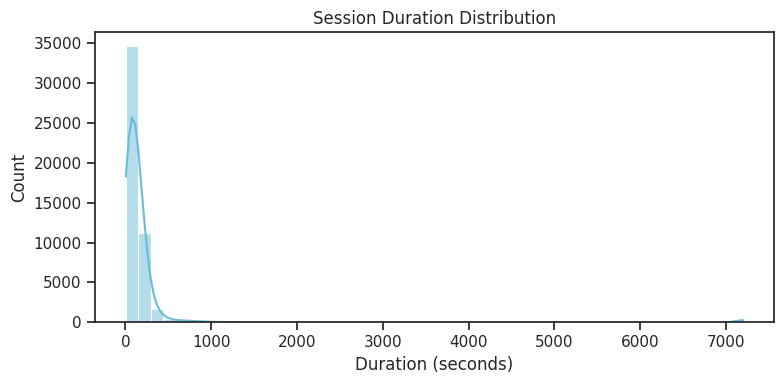

In [0]:
# Plot the distribution of session duration
plt.figure(figsize=(8,4))
sns.histplot(sl_df_analysis["session_duration"], bins=50, kde = True, color=travel_palette[2])
plt.title("Session Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.tight_layout()
plt.show()

**Note**: The **session_duration** variable measures how long each session lasted, expressed in seconds. The distribution is **strongly right-skewed**, with most sessions under 360 seconds (5 minutes). This indicates quick, goal-oriented interactions for the majority of users.  
A few extreme values extend the right tail of the distribution to 7000 seconds (120 minutes). 

###### Session Duration Distribution - Box Plot

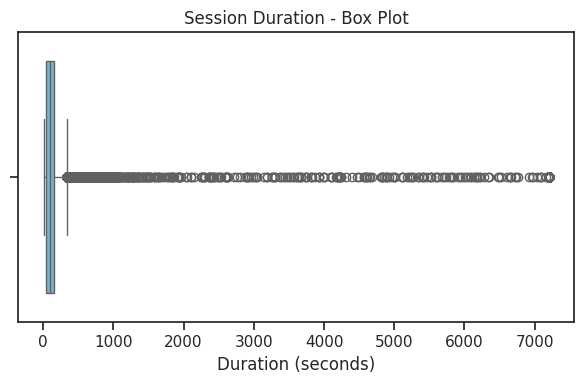

In [0]:
# Box plot for session duration
plt.figure(figsize=(6,4))
sns.boxplot(
    x=sl_df_analysis["session_duration"],
    color=travel_palette[2]
)
plt.title("Session Duration - Box Plot")
plt.xlabel("Duration (seconds)")
plt.tight_layout()
plt.show()


**Note**: The box plot confirms the presence of a long right tail in the session duration distribution.  
Most sessions are short, with a compact interquartile range.
Several outliers extend far beyond the upper whisker, reaching up to 7000 seconds (120 minutes).

This visualization complements the histogram by providing a concise summary of central tendency and dispersion.

##### 5.2.2 Page Clicks

###### Distribution of Page Clicks per Session - Histogram

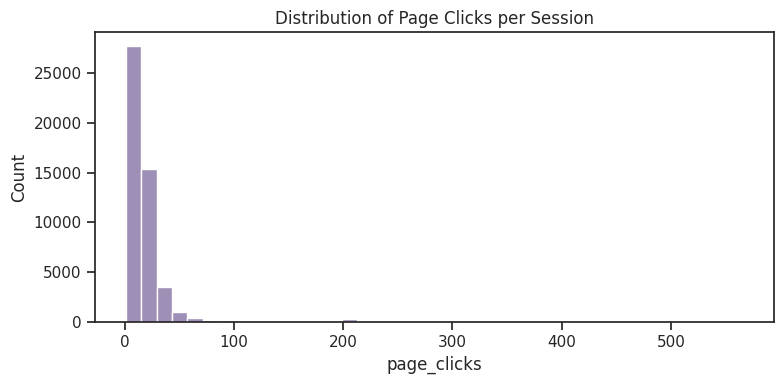

In [0]:
# Plot the distribution of page clicks
plt.figure(figsize=(8,4))
sns.histplot(sl_df_analysis["page_clicks"], bins=40, color=travel_palette[1])
plt.title("Distribution of Page Clicks per Session")
plt.tight_layout()
plt.show()

**Note**: The `page_clicks` variable captures how many actions a user performed during a session.
The distribution is again **right-skewed**, with most sessions involving fewer than 20 clicks. This aligns with the short durations observed earlier and reinforces the idea of fast, goal-oriented behavior. Sessions with high click counts may indicate deeper exploration or booking activity.

###### Distribution of Page Clicks - Box Plot

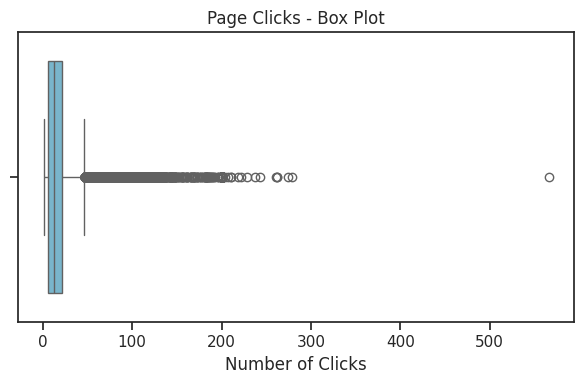

In [0]:
# Box plot for page_clicks
plt.figure(figsize=(6,4))
sns.boxplot(
    x=sl_df_analysis["page_clicks"],
    color=travel_palette[2] 
)
plt.title("Page Clicks - Box Plot")
plt.xlabel("Number of Clicks")
plt.tight_layout()
plt.show()


**Note**: The distribution of page clicks is right-skewed, with a narrow interquartile range and several high-value outliers. Given this asymmetry, median values will be preferred over means when aggregating user-level features, to ensure robust and representative metrics.  
An outlier of 566 page clicks, previously observed in the descriptive statistics, is clearly visible here. This extreme value likely represents an unusually long or highly interactive session, possibly caused by repeated navigation loops, extensive comparison behavior, or automated activity.

###### Page Clicks vs Session Duration - Scatter Plot 

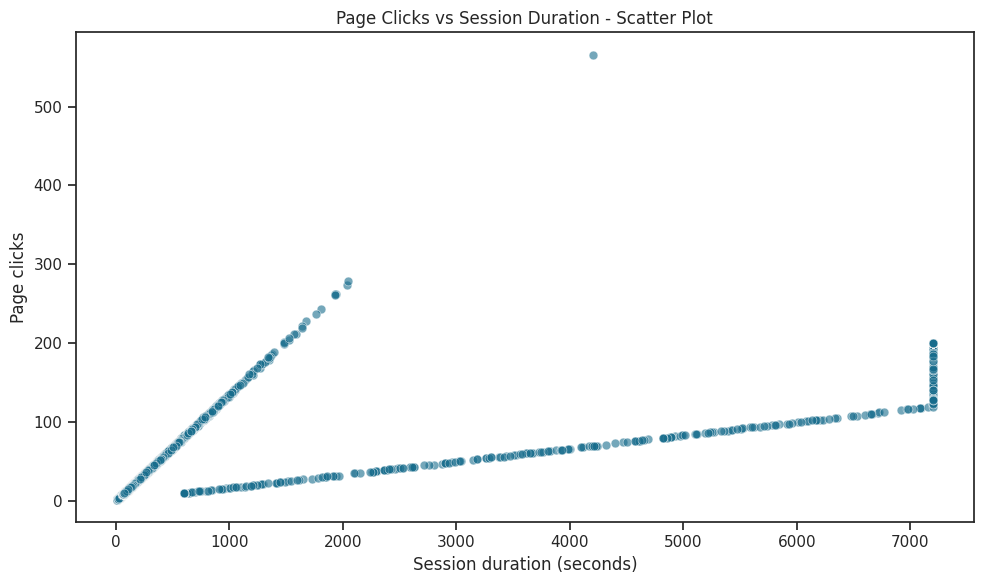

In [0]:
# Page Clicks vs  Session Duration Scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=sl_df_analysis,
    x="session_duration",
    y="page_clicks",
    alpha=0.6,
    s=40,
    color=[travel_palette[0]] 
)
plt.title("Page Clicks vs Session Duration - Scatter Plot")
plt.xlabel("Session duration (seconds)")
plt.ylabel("Page clicks")
plt.tight_layout()
plt.show()

**Note**: Page clicks generally increase with session duration, though the relationship is non-linear and shows substantial dispersion.

###### Page Clicks vs Session Duration (Flight Booked) - Scatter Plot

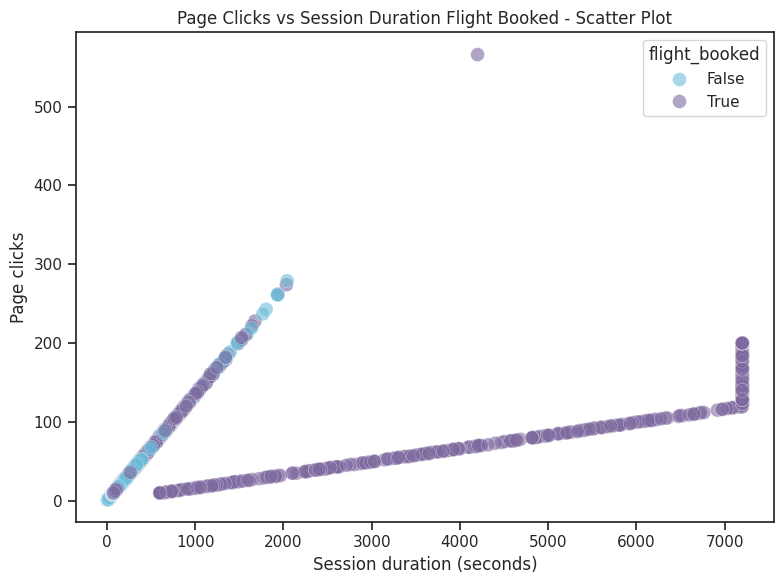

In [0]:
# Page Clicks vs Session Duration (Flight Booked) - Scatter Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=sl_df_analysis,
    x="session_duration",
    y="page_clicks",
    hue="flight_booked",
    alpha=0.6,
    linewidth=0.3,
    edgecolor="white",
    s=100,
    palette=[travel_palette[2], travel_palette[1]] 
)
plt.title("Page Clicks vs Session Duration Flight Booked - Scatter Plot")
plt.xlabel("Session duration (seconds)")
plt.ylabel("Page clicks")
plt.tight_layout()
plt.show()

**Note**: Compared to the overall scatter plot, adding the flight-booking hue reveals that booking sessions follow a distinct engagement pattern:  
page clicks tend to rise more gradually as session duration increases, and a dense cluster emerges at longer durations.  
This suggests that flight-related decisions often involve more deliberate, extended navigation than non-booking sessions.

Notably, the extreme outlier previously observed in the descriptive statistics, a session with **566 page clicks**,  is visible here and corresponds to a **booking session**.  
This reinforces the idea that high engagement outliers are not random noise, but may reflect genuine conversion behavior, such as intensive comparison, repeated navigation loops, or multi-tab exploration.

Page clicks and session duration are related but not redundant.  
They capture different dimensions of user behavior, one temporal, one interactive, and should be treated as complementary signals in user-level aggregation.


#### 5.3 Booking Behavior
Before analyzing booking and cancellation metrics, it is important to clarify how user behavior unfolds across sessions and trips in the dataset.

Understanding cancellation behaviour requires looking at how trips evolve across different session types.

Each trip in the dataset follows a simple and well-defined lifecycle.
A trip begins with a booking session (`cancellation = False` and at least one product booked), always identified by a `trip_id`.  
Browsing sessions contain no bookings and therefore no `trip_id`.

A cancellation session (`cancellation = True`) always refers to a previously booked trip and uses the same `trip_id` to link back to its products.

This structure clearly distinguishes browsing, booking, and cancellation behaviour, and allows us to analyze how often trips are reversed and which
product combinations are most affected.

##### 5.3.1 Booking Signals

###### Hotel Booking - Bar Plot

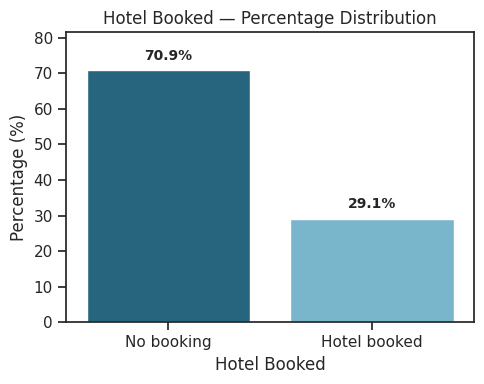

In [0]:
# Percentage distribution of hotel bookings

# Consider only sessions where a booking could occur (exclude cancellations) 
df_bookings = sl_df_analysis[sl_df_analysis["cancellation"] == False]

# Compute percentage values of hotel_booked
hotel_pct = (
    df_bookings["hotel_booked"]
    .value_counts(normalize=True)
    .sort_index()
    * 100
)
hotel_pct.index = hotel_pct.index.map({False: "No booking", True: "Hotel booked"})

plt.figure(figsize=(5,4))
# Bar plot of percentages
sns.barplot(
    x=hotel_pct.index.astype(str), # Convert boolean to string for cleaner labels
    y=hotel_pct.values,
    hue = hotel_pct.index.astype(str),
    palette=[travel_palette[0], travel_palette[2]]
)

plt.title("Hotel Booked — Percentage Distribution")
plt.xlabel("Hotel Booked")
plt.ylabel("Percentage (%)")

# Add a bit of headroom above the tallest bar
plt.ylim(0, hotel_pct.max() * 1.15)

# Add percentage labels on top of bars
for i, value in enumerate(hotel_pct.values):
    plt.text(
        i,
        value + hotel_pct.max() * 0.03,
        f"{value:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )
plt.tight_layout()
plt.show()


**Note**: Only about 29% of sessions result in a hotel booking, confirming that this is a relatively rare event. The imbalance between booking and non-booking sessions suggests that raw counts would overrepresent users with high activity.

###### Flight Booking - Bar Plot

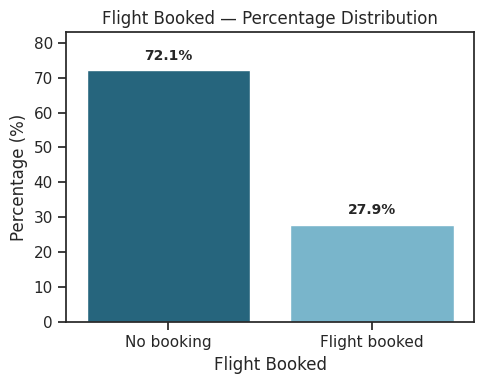

In [0]:
# Percentage distribution of flight bookings without cancellation
flight_pct = (
    df_bookings["flight_booked"]
    .value_counts(normalize=True)
    .sort_index()
    * 100
)

flight_pct.index = flight_pct.index.map({False: "No booking", True: "Flight booked"})

plt.figure(figsize=(5,4))

sns.barplot(
    x=flight_pct.index.astype(str),
    y=flight_pct.values,
    hue = flight_pct.index.astype(str),
    palette=[travel_palette[0], travel_palette[2]]
)

plt.title("Flight Booked — Percentage Distribution")
plt.xlabel("Flight Booked")
plt.ylabel("Percentage (%)")
plt.ylim(0, flight_pct.max() * 1.15)

# Add percentage labels on top of bars
for i, value in enumerate(flight_pct.values):
    plt.text(
        i,
        value + flight_pct.max() * 0.03,
        f"{value:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


**Note**: Flight bookings occur in less than 28% of sessions, reinforcing the idea that conversion signals are sparse. Users with many sessions might accumulate bookings simply due to volume, not behavior.

###### Trip Behavior - Bar Plot

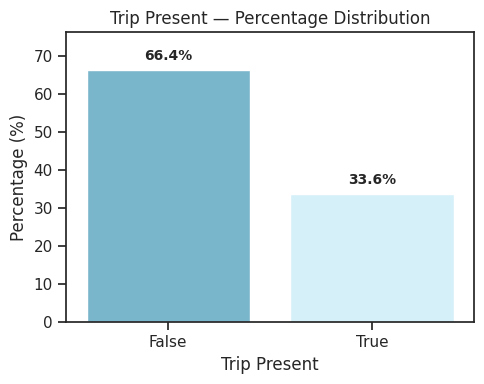

In [0]:
# Percentage distribution of sessions with a trip_id present 

# Convert trip_id to a boolean: True if present, False if missing
trip_present = sl_df_analysis["trip_id"].notna()

trip_pct = (
    trip_present
    .value_counts(normalize=True)
    .sort_index()
    * 100
)

plt.figure(figsize=(5,4))

sns.barplot(
    x=trip_pct.index.map({False: "False", True: "True"}),  # Clean labels
    y=trip_pct.values,
    hue = trip_pct.index.map({False: "False", True: "True"}),
    palette=[travel_palette[2], travel_palette[3]]
)

plt.title("Trip Present — Percentage Distribution")
plt.xlabel("Trip Present")
plt.ylabel("Percentage (%)")
plt.ylim(0, trip_pct.max() * 1.15)

# Add percentage labels on top of bars
for i, value in enumerate(trip_pct.values):
    plt.text(
        i,
        value + trip_pct.max() * 0.03, 
        f"{value:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


**Note**: Trip IDs are present in roughly one-third of sessions (booking and cancellation sessions), indicating that full itinerary planning is not the norm. This further supports the need to normalize booking signals when aggregating user-level features.

###### Booking Signals - Summary Table

In [0]:
# Summary table for booking signals (counts + percentages)

# --- Hotel booking ---
hotel_counts = (
    df_bookings["hotel_booked"]
    .value_counts()
    .rename(index={True: "Hotel booked", False: "No hotel booking"})
    .to_frame("count")
)
hotel_counts["percentage"] = (
    round(hotel_counts["count"] / hotel_counts["count"].sum(), 4) * 100
)

# --- Flight booking ---
flight_counts = (
    df_bookings["flight_booked"]
    .value_counts()
    .rename(index={True: "Flight booked", False: "No flight booking"})
    .to_frame("count")
)
flight_counts["percentage"] = (
    round(flight_counts["count"] / flight_counts["count"].sum(), 4) * 100
)

# --- Trip ID presence ---
trip_counts = (
    sl_df_analysis["trip_id"].notna()
    .value_counts()
    .rename(index={True: "Has trip_id", False: "No trip_id"})
    .to_frame("count")
)
trip_counts["percentage"] = (
    round(trip_counts["count"] / trip_counts["count"].sum(), 4) * 100
)

# Combine all into a single table
booking_summary = pd.concat(
    [hotel_counts, flight_counts, trip_counts],
    axis=0
)

booking_summary


,count,percentage
No hotel booking,34295,70.88
Hotel booked,14087,29.12
No flight booking,34891,72.12
Flight booked,13491,27.88
No trip_id,32509,66.36
Has trip_id,16478,33.64


**Note**: Across all three booking signals, `hotel_booked`, `flight_booked`, and `trip_id` presence, 
the data shows a consistent pattern: these events occur in a minority of sessions. 
Only about one third of all sessions involve a `trip_id`, and an even smaller share contains a hotel or flight booking.

This sparsity has important implications for user-level analysis. Raw counts of  bookings or trip initiations would mostly reflect how many sessions a user generates, rather than their true propensity to engage with booking features. 
For this reason, normalized metrics such as `hotel_booking_rate`, `flight_booking_rate`, and `trip_creation_rate` provide a far more stable and comparable representation of user behavior.

##### 5.3.2 Session Lifecycle Classification

###### Classification Categories Definition

In [0]:
# Identify cancelled trips at trip level
cancelled_trips = set(
    sl_df_analysis.loc[sl_df_analysis["cancellation"] == True, "trip_id"]
    .dropna()
    .unique()
)
def classify_lifecycle(row):
    # No trip_id present, pure browsing
    if pd.isna(row["trip_id"]):
        return "browsing_session"
    
    # Cancellation session
    if row["cancellation"]:
        return "cancellation_session"
    
    # Booking sessions (cancellation == False, trip_id present)
    if row["trip_id"] in cancelled_trips:
        return "unconverted_booking_session"
    return "converted_booking_session"

sl_df_analysis["session_category"] = sl_df_analysis.apply(classify_lifecycle, axis=1)

###### Session Classification - Table

In [0]:
# Session type counts 
session_type_counts = (
    sl_df_analysis["session_category"]
    .value_counts()
    .rename_axis("session_type")
    .to_frame("count")
)
# Percentage of session types
session_type_counts["percentage"] = (
    session_type_counts["count"] / session_type_counts["count"].sum() * 100
).round(2)

session_type_counts


,count,percentage
session_type,,
browsing_session,32509,66.36
converted_booking_session,15268,31.17
cancellation_session,605,1.24
unconverted_booking_session,605,1.24


In [0]:
# Conversion rate of booking sessions
booking_sessions = sl_df_analysis["session_category"].isin(
    ["converted_booking_session", "unconverted_booking_session"]
)

conversion_rate = (
    (sl_df_analysis["session_category"] == "converted_booking_session").sum()
    / booking_sessions.sum()
)

print("Conversion rate:", round(float(conversion_rate) * 100, 2), "%")


Conversion rate: 96.19 %


**Note**: Conditional on a booking occurring, approximately **96% of booking sessions remain converted**, while only **4% are later cancelled**. This confirms that cancellations are a relatively rare downstream event.

###### Session Classification - Bar Plot

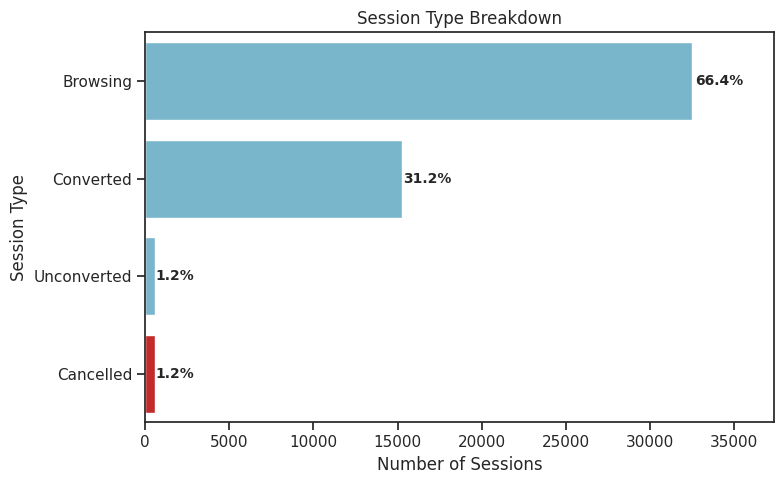

In [0]:
# Extract values directly from the previous table
labels = session_type_counts.index
counts = session_type_counts["count"].values
pcts = session_type_counts["percentage"].values

# Custom labels for the Y axis
custom_labels = ["Browsing", "Converted", "Unconverted", "Cancelled"]

plt.figure(figsize=(8,5))

palette = [travel_palette[2], travel_palette[2], travel_palette[2], '#DD1111']

bp = sns.barplot(
    y=custom_labels,
    x=counts,
    hue=labels,
    palette=palette,
    dodge=False
)

plt.title("Session Type Breakdown")
plt.xlabel("Number of Sessions")
plt.ylabel("Session Type")
plt.tight_layout()

# Add percentage labels at the end of each bar
for i, (count, pct) in enumerate(zip(counts, pcts)):
    bp.text(
        count + (count * 0.005),   # slightly to the right of the bar
        i,
        f"{pct:.1f}%",
        va="center",
        fontsize=10,
        fontweight="bold"
    )

# Remove the legend
bp.legend_.remove()
# Add extra space for the percentage labels
bp.set_xlim(0, counts.max() * 1.15)
plt.show()


**Note**: This breakdown classifies every session into one of four mutually exclusive lifecycle categories:

- **browsing_session**: no trip created, no booking activity  
- **converted_booking_session**: a booking was made and remained valid  
- **unconverted_booking_session**: a booking was made but later cancelled  
- **cancellation_session**: the session where the cancellation actually occurred

The counts for *unconverted_booking_session* and *cancellation_session* are identical.  
This reflects the structure of the dataset: each cancelled trip generates exactly two distinct sessions one where the booking was initiated, and one where it was cancelled. These are separate events with different session IDs, but they occur in a 1:1 relationship.

Browsing sessions dominate the dataset, accounting for over two-thirds of all activity.  
Converted bookings represent nearly one-third, while cancellations are relatively rare.  
This classification provides a clean foundation for analyzing booking behavior, cancellation dynamics, and user-level conversion patterns in the sections that follow.


##### 5.3.3 Booking Session Product Mix

###### Session Booking Classification

In [0]:
# Select only booking sessions (confirmed + unconverted)
df_bookings = sl_df_analysis[
    sl_df_analysis["session_category"].isin([
        "converted_booking_session",
        "unconverted_booking_session"
    ])
].copy()


In [0]:
# Classify the booked products
def classify_booking_type(row):
    # Hotel + Flight
    if row["hotel_booked"] and row["flight_booked"]:
        return "hotel + flight"
    # Hotel only
    elif row["hotel_booked"]:
        return "hotel only"
    # Flight only
    elif row["flight_booked"]:
        return "flight only"
    else:
        return "none"  # should never happen


In [0]:
# Save the classification in df_bookings under the column "booking_type"
df_bookings["booking_type"] = df_bookings.apply(classify_booking_type, axis=1)

###### Booking Session Type - Table

In [0]:
# Count booking types 
booking_type_counts = (
    df_bookings["booking_type"]
    .value_counts()
    .reindex(["hotel only", "flight only", "hotel + flight"])
    .to_frame("count")
)

# Compute the percentage of each booking type
booking_type_counts["percentage"] = (
    booking_type_counts["count"] / booking_type_counts["count"].sum() * 100
).round(2)

booking_type_counts


,count,percentage
booking_type,,
hotel only,2382,15.01
flight only,1786,11.25
hotel + flight,11705,73.74


###### Booking Session Type - Bar Plot

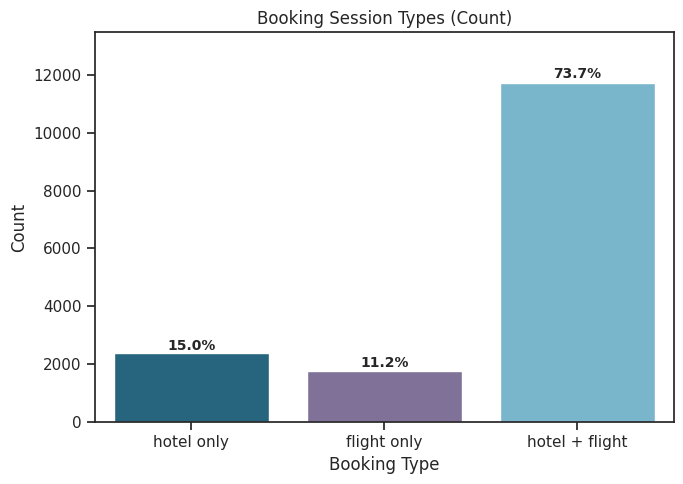

In [0]:
counts = booking_type_counts["count"].values 
pcts = booking_type_counts["percentage"].values 
labels = booking_type_counts.index

# Bar plot of session types (counts)
plt.figure(figsize=(7,5))

bp = sns.barplot(
    x=labels,
    y=counts,
    hue=labels,
    palette=[travel_palette[0], travel_palette[1], travel_palette[2]]
)

plt.title("Booking Session Types (Count)")
plt.xlabel("Booking Type")
plt.ylabel("Count")
plt.tight_layout()

# Add percentage labels above each bar 
for i, (count, pct) in enumerate(zip(counts, pcts)): 
    bp.text( 
        i, count + (count * 0.005), # position slightly above the bar 
        f"{pct:.1f}%", # format percentage 
        ha="center", va="bottom", fontsize=10, fontweight="bold"
    )
bp.set_ylim(0, counts.max() * 1.15)
plt.show()


**Note**: This breakdown considers only booking sessions, both converted and unconverted, 
that contain an actual booking action. Within these sessions, three mutually 
exclusive booking types emerge:

- **hotel only**: sessions where only a hotel was booked  
- **flight only**: sessions where only a flight was booked  
- **hotel + flight**: sessions where both products were booked together  

Most booking sessions involve a combined hotel + flight booking, while single-product bookings (hotel only or flight only) represent a smaller share.  
This distribution highlights how users typically engage with TravelTide's booking features once they initiate a trip, showing a clear preference for bundled hotel and flight bookings.


##### 5.3.4 Booking vs Cancellations

In [0]:

# Recreate product presence flags for analysis
sl_df_analysis["flight_data_present"] = sl_df_analysis["base_fare_usd"].notnull()
sl_df_analysis["hotel_data_present"] = sl_df_analysis["hotel_per_room_usd"].notnull()
sl_df_analysis["trip_present"] = sl_df_analysis["trip_id"].notnull()

df_book = sl_df_analysis[sl_df_analysis["cancellation"] == False].copy() 
df_canc = sl_df_analysis[sl_df_analysis["cancellation"] == True].copy()



In [0]:
df_book_hotel = df_book[df_book["hotel_booked"] == True]
df_book_flight = df_book[df_book["flight_booked"] == True]

df_canc_hotel = df_canc[df_canc["hotel_data_present"] == True]
df_canc_flight = df_canc[df_canc["flight_data_present"] == True]


###### Booking vs Cancellation by Product Type - Table

In [0]:
# Bookings (converted + unconverted)
hotel_only_book = df_bookings[(df_bookings["hotel_booked"]) & (~df_bookings["flight_booked"])].shape[0]
flight_only_book = df_bookings[(df_bookings["flight_booked"]) & (~df_bookings["hotel_booked"])].shape[0]
both_book = df_bookings[(df_bookings["hotel_booked"]) & (df_bookings["flight_booked"])].shape[0]

# Cancellations
hotel_only_canc = df_canc[(df_canc["hotel_data_present"]) & (~df_canc["flight_data_present"])].shape[0]
flight_only_canc = df_canc[(df_canc["flight_data_present"]) & (~df_canc["hotel_data_present"])].shape[0]
both_canc = df_canc[(df_canc["hotel_data_present"]) & (df_canc["flight_data_present"])].shape[0]

# --- SUMMARY TABLE ---
booking_vs_canc = pd.DataFrame({
    "product_type": ["hotel only", "flight only", "hotel + flight"],
    "bookings": [hotel_only_book, flight_only_book, both_book],
    "cancellations": [hotel_only_canc, flight_only_canc, both_canc]
})

booking_vs_canc["cancellation_rate"] = (
    booking_vs_canc["cancellations"] / booking_vs_canc["bookings"] * 100
).round(1)

booking_vs_canc


,product_type,bookings,cancellations,cancellation_rate
0,hotel only,2382,50,2.1
1,flight only,1786,193,10.8
2,hotel + flight,11705,362,3.1


###### Bookings vs Cancellations by Product Type - Bar Plot

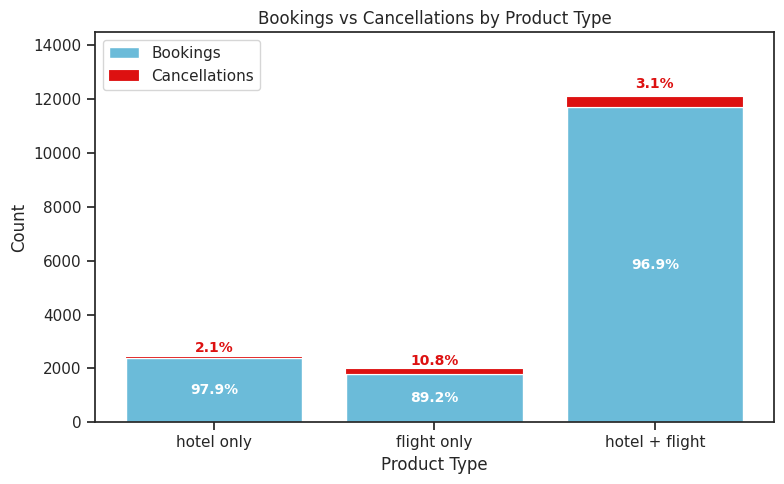

In [0]:
# Bar plot of bookings vs cancellations by product type
booking_vs_canc["cancellation_rate"]  # in %



plt.figure(figsize=(8,5))

# Bookings (base)
plt.bar(
    booking_vs_canc["product_type"],
    booking_vs_canc["bookings"],
    label="Bookings",
    color=travel_palette[2]
)

# Cancellations (stacked)
plt.bar(
    booking_vs_canc["product_type"],
    booking_vs_canc["cancellations"],
    bottom=booking_vs_canc["bookings"],
    label="Cancellations",
    color="#DD1111",
    linewidth=0.1
)

plt.title("Bookings vs Cancellations by Product Type")
plt.xlabel("Product Type")
plt.ylabel("Count")
plt.legend()

# add percentage labels
for i, row in booking_vs_canc.iterrows():
    
    # Booking percentage (inside base bar)
    booking_pct = 100 - row["cancellation_rate"]
    plt.text(
        i,
        row["bookings"] * 0.5,
        f"{booking_pct:.1f}%",
        ha="center",
        va="center",
        fontsize=10,
        fontweight="bold",
        color="white"
       
    )
    
    # Cancellation percentage (above the stacked bar)
    plt.text(
        i,
        row["bookings"] + row["cancellations"] + (row["bookings"] * 0.02),
        f"{row['cancellation_rate']:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
        color="#DD1111",
    )
# more space above
y_max = (booking_vs_canc["bookings"] + booking_vs_canc["cancellations"]).max()
plt.ylim(0, y_max * 1.20)

plt.tight_layout()
plt.show()


**Note**: This comparison links booking activity to subsequent cancellations for each product type.  
Cancellation counts are computed using product-level data presence in cancellation sessions, ensuring that only true hotel-only, flight-only, and combined cancellations are included.

Key patterns emerge:

- **Hotel-only bookings** show a very low cancellation rate (2.1%), indicating that users who book only accommodation tend to follow through with their plans.  
- **Flight-only bookings** exhibit the highest cancellation rate (10.8%), suggesting greater volatility or uncertainty in flight-related decisions.  
- **Hotel + Flight bookings** have a moderate cancellation rate (3.1%), much lower than flight-only bookings. This indicates that users who book full itineraries are more committed and less likely to cancel.

Overall, combined bookings appear to be the most stable product category, while flight-only bookings show the highest likelihood of being reversed.  
The accompanying bar plot visually reinforces this pattern, showing the relative volume of bookings and cancellations across product types.

##### 5.3.5 Booking vs Engagement

In [0]:
# Create a binary flag indicating whether a session contains any booking 
sl_df_analysis["any_booking"] = (
    (sl_df_analysis["cancellation"] == False) &
    (sl_df_analysis["hotel_booked"] | sl_df_analysis["flight_booked"])
)

# Compute session duration in seconds 
sl_df_analysis["session_duration"] = ( sl_df_analysis["session_end"] - sl_df_analysis["session_start"] ).dt.total_seconds()

In [0]:
sl_df_analysis["session_duration"].describe()

count    48987.000000
mean       186.688426
std        659.351758
min          6.000000
25%         45.000000
50%         95.000000
75%        161.000000
max       7200.000000
Name: session_duration, dtype: float64

###### Session Duration -Booking vs Non-Booking - Box Plot

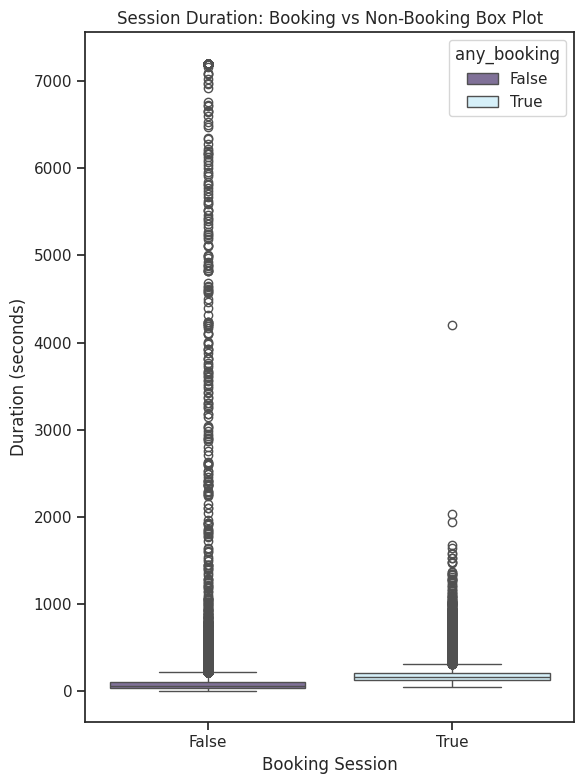

In [0]:
# Box plot: session duration for booking vs non-booking sessions
plt.figure(figsize=(6,8))

sns.boxplot(
    data=sl_df_analysis,
    x="any_booking",
    y="session_duration",
    hue = "any_booking",
    palette=[travel_palette[1], travel_palette[3]]
)

plt.title("Session Duration: Booking vs Non-Booking Box Plot")
plt.xlabel("Booking Session")
plt.ylabel("Duration (seconds)")
plt.tight_layout()
plt.show()


**Note**: Booking sessions have a higher median session duration and median page clicks, indicating more deliberate and interaction-dense behavior during conversion.
At the same time, their lower standard deviation suggests more consistent engagement patterns.
Non-booking sessions exhibit much higher variability, including extreme long-duration and high-click outliers, reflecting exploratory or indecisive behavior.

###### Page Clicks -Booking vs Non-Booking - Box Plot

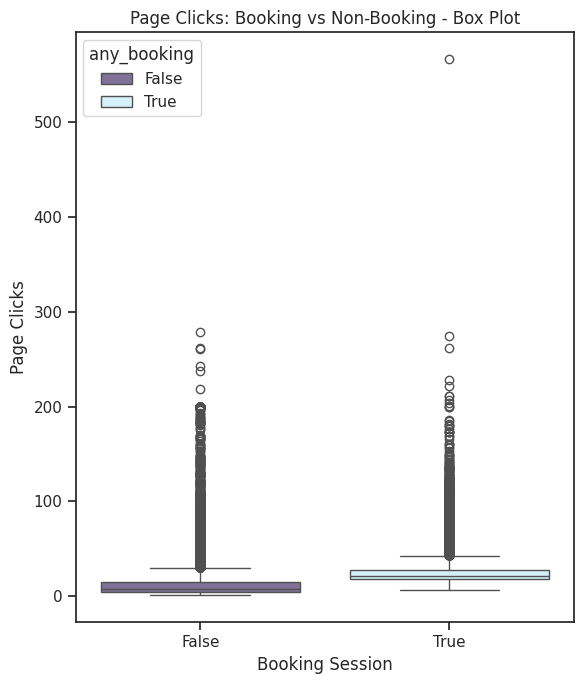

In [0]:
# Box plot: page clicks for booking vs non-booking sessions
plt.figure(figsize=(6,7))

sns.boxplot(
    data=sl_df_analysis,
    x="any_booking",
    y="page_clicks",
    hue = "any_booking",
    palette=[travel_palette[1], travel_palette[3]]
)

plt.title("Page Clicks: Booking vs Non-Booking - Box Plot")
plt.xlabel("Booking Session")
plt.ylabel("Page Clicks")
plt.tight_layout()
plt.show()


**Note**: This comparison isolates sessions with and without booking activity, using the `any_booking` flag.  
Sessions marked as `True` include at least one product booking (hotel or flight), while `False` sessions represent pure browsing behavior.

The boxplot shows that booking sessions tend to be more focused and compact in duration, while non-booking sessions exhibit a wider range and more extreme outliers.  
This suggests that users who do not convert may spend more time exploring or hesitating, whereas booking sessions are typically more decisive.


###### Summary Statistics

In [0]:
# Summary statistics for engagement metrics by booking flag
engagement_summary = (
    sl_df_analysis
    .groupby("any_booking")[["session_duration", "page_clicks"]]
    .agg(["mean", "median", "std"])
)

engagement_summary


session_duration                    page_clicks                  
                        mean median         std        mean median        std
any_booking                                                                  
False             184.286704   60.0  796.873917   13.581295    8.0  22.076992
True              191.698860  160.0  130.135229   25.788761   22.0  17.547769

**Note**: The summary statistics reveal clear behavioral differences between booking and non-booking sessions:

- **Session Duration**:  
  Booking sessions have a higher median duration (160s vs 60s), but a lower standard deviation.  
  This indicates that booking sessions are more consistently focused, while non-booking sessions vary widely, some are very short, others extremely long.

- **Page Clicks**:  
  Booking sessions show significantly higher engagement, with a median of 22 clicks compared to just 8 in non-booking sessions.  
  The lower standard deviation in booking sessions suggests more consistent interaction depth.

Overall, booking sessions are longer, more interactive, and more stable in behavior, reinforcing the idea that conversion is typically preceded by deliberate and engaged navigation.


#### 5.4 Temporal Patterns

In [0]:
# Extract hour of day from session_start
sl_df_analysis["hour"] = sl_df_analysis["session_start"].dt.hour

# Count sessions per hour
hour_counts = (sl_df_analysis["hour"].value_counts().sort_index())

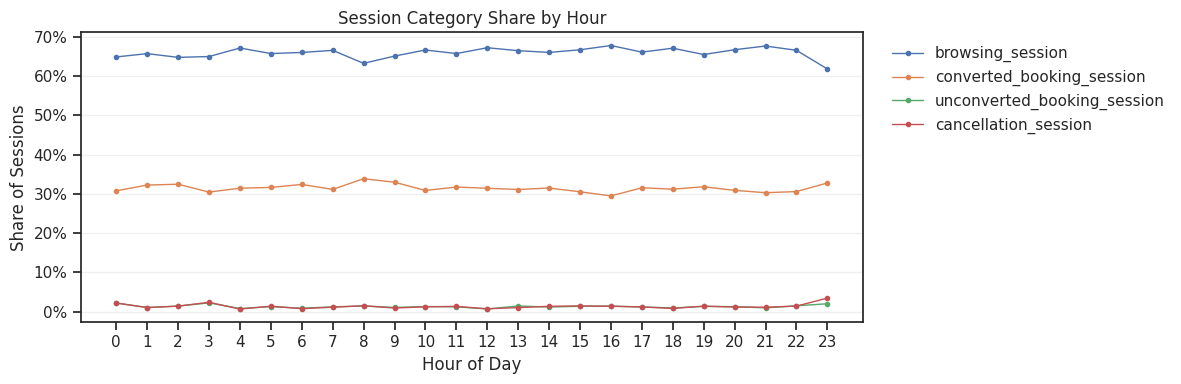

In [0]:
import matplotlib.ticker as mtick

# share by Hour per session categories
hour_cat = (
    sl_df_analysis
    .groupby(["hour", "session_category"])
    .size()
    .unstack(fill_value=0)
)

hour_share = hour_cat.div(hour_cat.sum(axis=1), axis=0)

plt.figure(figsize=(12,4))
for col in ["browsing_session","converted_booking_session","unconverted_booking_session","cancellation_session"]:
    if col in hour_share.columns:
        plt.plot(hour_share.index, hour_share[col], marker="o", markersize=3, linewidth=1, label=col)

plt.title("Session Category Share by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Share of Sessions")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(range(0,24,1))
plt.grid(axis="y", alpha=0.3)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()


**Note**: The relative share of session categories remains remarkably stable across the day.
Browsing sessions consistently account for 65% of activity, while converted bookings remain around 30-33%, indicating no meaningful time-of-day effect on conversion behavior.

##### 5.4.1 Weekday

In [0]:
# weekday order
weekday_order = [ "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday" ]

# Extract weekday name from session_start
sl_df_analysis["weekday"] = sl_df_analysis["session_start"].dt.day_name()


###### Booking Rate per Weekday - Bar Plot

In [0]:
# Compute booking rate per weekday
weekday_booking_rate = (
    sl_df_analysis.groupby("weekday")["any_booking"]
    .mean()  # mean of boolean = rate
    .reindex(weekday_order)
)

/home/spark-46f7e9dd-686e-472c-8502-97/.ipykernel/2596/command-8168889369778120-794264787:4: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.barplot(


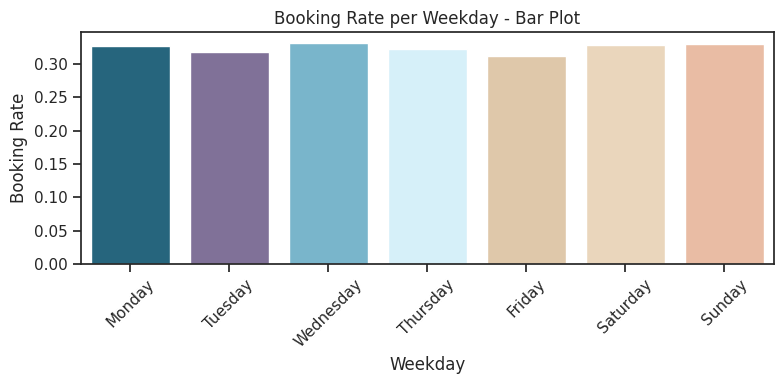

In [0]:
# Bar plot: booking rate per weekday
plt.figure(figsize=(8,4))

sns.barplot(
    x=weekday_booking_rate.index,
    y=weekday_booking_rate.values,
    hue = weekday_booking_rate.index,
    palette=travel_palette
)

plt.title("Booking Rate per Weekday - Bar Plot")
plt.xlabel("Weekday")
plt.ylabel("Booking Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Note**: Weekday patterns appear relatively flat, with booking rates and session volumes showing minimal variation across the week. As a result, user-level features based on weekday/weekend ratios are unlikely to provide meaningful predictive value.

##### 5.4.2 Time of Day

###### Session Count per Hour of Day - Bar Plot

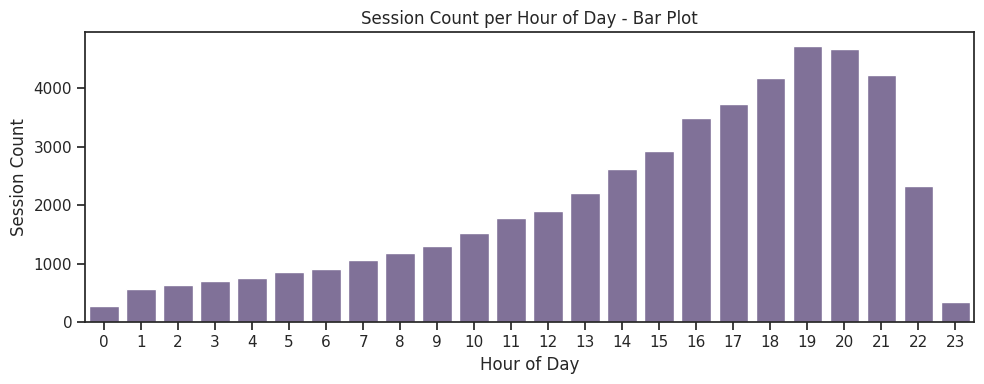

In [0]:
# Bar plot: session count per hour
plt.figure(figsize=(10,4))

sns.barplot(
    x=hour_counts.index,
    y=hour_counts.values,
    color = travel_palette[1]
)

plt.title("Session Count per Hour of Day - Bar Plot")
plt.xlabel("Hour of Day")
plt.ylabel("Session Count")
plt.tight_layout()
plt.show()

**Note**: Session activity gradually increases throughout the day, reaching a peak between 18:00 and 20:00, followed by a sharp decline after 21:00. This indicates that session volume is concentrated in the early evening, consistent with typical post-work usage patterns.

#### 5.5 Price and Discount Signals

The goal of this section is to assess whether price and discount signals carry stable and meaningful behavioral information that can be aggregated at user level for segmentation, or whether they are too sparse or noisy and should be excluded.

##### 5.5.1 Flight Prices

In [0]:
# Filter booked flight sessions
df_bookings = sl_df_analysis[
    sl_df_analysis["session_category"].isin([
        "converted_booking_session",
        "unconverted_booking_session"
    ])
]

booked_flights = df_bookings[df_bookings["flight_booked"] == True]

###### Flight Base Fare Distribution (Booked Only) - Histogram

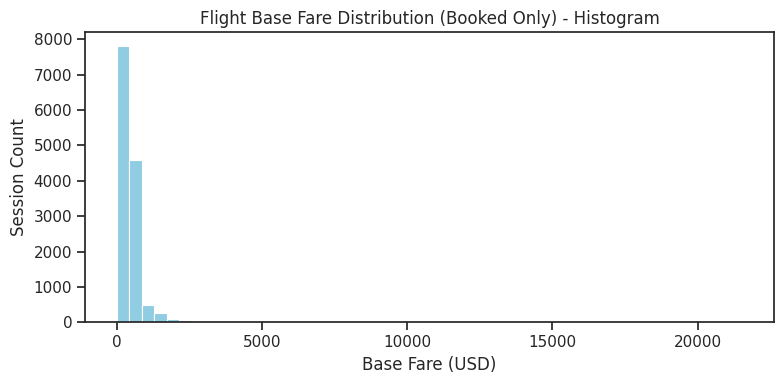

In [0]:
# Histogram of base_fare_usd for booked flights
plt.figure(figsize=(8,4))

sns.histplot(
    data=booked_flights,
    x="base_fare_usd",
    bins=50,
    kde=False,
    color=travel_palette[2]
)

plt.title("Flight Base Fare Distribution (Booked Only) - Histogram")
plt.xlabel("Base Fare (USD)")
plt.ylabel("Session Count")
plt.tight_layout()
plt.show()


**Note**: Most booked flights fall in the lower fare range, with a sharp drop-off as prices increase, indicating strong user preference for budget options.

In [0]:
booked_flights["base_fare_usd"].describe()

count    13491.000000
mean       492.560486
std        706.415424
min          2.410000
25%        198.225000
50%        378.960000
75%        592.740000
max      21548.040000
Name: base_fare_usd, dtype: float64

###### Flight Base Fare Distribution - Box Plot

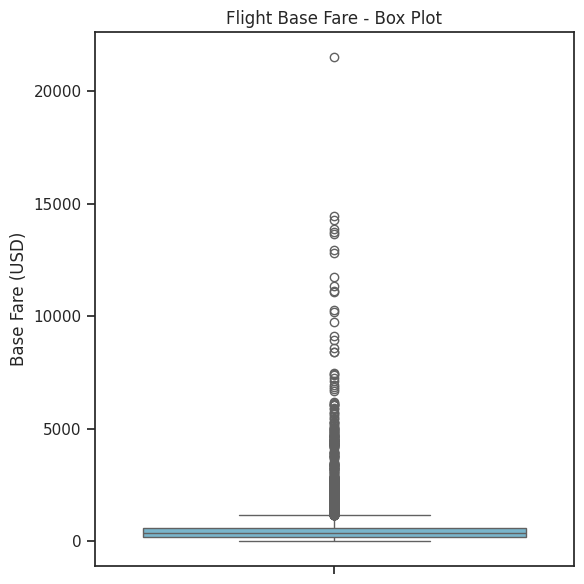

In [0]:
# Box plot of base_fare_usd for booked flights
plt.figure(figsize=(6,6))

sns.boxplot(
    data=booked_flights,
    y="base_fare_usd",
    color=travel_palette[2]
)

plt.title("Flight Base Fare - Box Plot")
plt.ylabel("Base Fare (USD)")
plt.tight_layout()
plt.show()


**Note**: Flight fares show high variability and extreme outliers, with most bookings concentrated below $1,000 and a few exceeding $20,000.

##### 5.5.2 Hotel Prices

###### Hotel Price per Room (Booked Only) - Histogram

In [0]:
# Filter booked hotel sessions
booked_hotels = booked_hotels = df_bookings[df_bookings["hotel_booked"] == True]

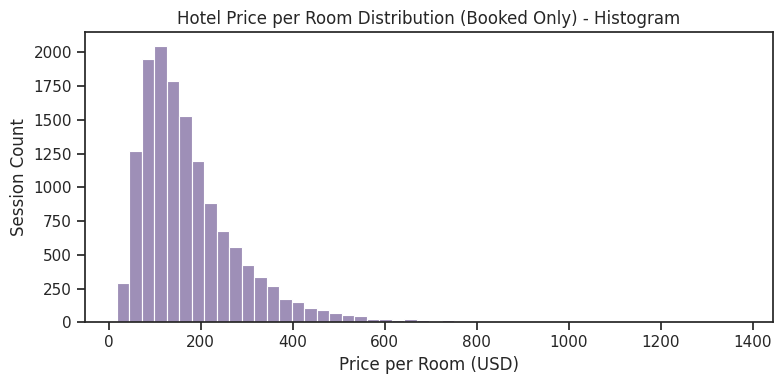

In [0]:
# Histogram of hotel_per_room_usd
plt.figure(figsize=(8,4))

sns.histplot(
    data=booked_hotels,
    x="hotel_per_room_usd",
    bins=50,
    kde=False,
    color=travel_palette[1]
)

plt.title("Hotel Price per Room Distribution (Booked Only) - Histogram")
plt.xlabel("Price per Room (USD)")
plt.ylabel("Session Count")
plt.tight_layout()
plt.show()


**Note**: Booked hotel rooms are concentrated in the $50-$200 range, with fewer sessions at higher price points, suggesting most users prefer budget to mid-range accommodations.

##### 5.5.3 Discounts

###### Percentage Session with Discount (Flight vs Hotel) - Bar Chart

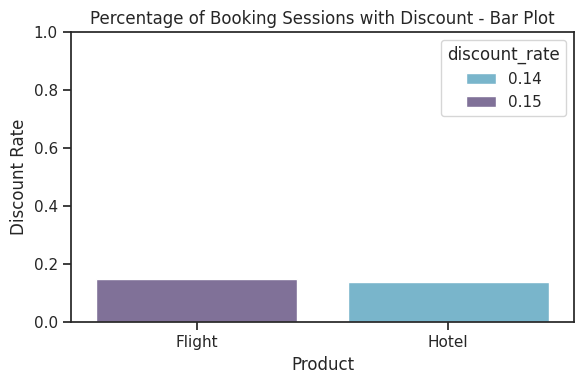

In [0]:
# Compute discount rates for flight and hotel
flight_discount_rate = df_bookings["flight_discount"].mean().round(2)
hotel_discount_rate  = df_bookings["hotel_discount"].mean().round(2)

discount_df = pd.DataFrame({
    "product": ["Flight", "Hotel"],
    "discount_rate": [flight_discount_rate, hotel_discount_rate]
})

# Bar plot: percentage of sessions with discount
plt.figure(figsize=(6,4))

sns.barplot(
    data=discount_df,
    x="product",
    y="discount_rate",
    hue="discount_rate",
    palette=[travel_palette[2], travel_palette[1]]
)

plt.title("Percentage of Booking Sessions with Discount - Bar Plot")
plt.xlabel("Product")
plt.ylabel("Discount Rate")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


**Note**: Discounts are relatively rare overall, with flight sessions showing a slightly higher discount rate than hotel sessions.

###### Flight Discount Amount Distribution (Booked Only) - Histogram

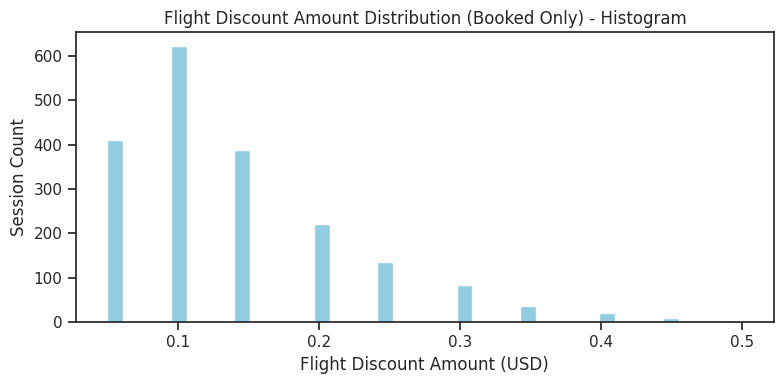

In [0]:
# Filter booked flights with discount amount
flight_disc_booked = df_bookings[
    (df_bookings["flight_booked"]) &
    (df_bookings["flight_discount_amount"].notnull())
]

plt.figure(figsize=(8,4))

sns.histplot(
    data=flight_disc_booked,
    x="flight_discount_amount",
    bins=40,
    kde=False,
    color=travel_palette[2]
)

plt.title("Flight Discount Amount Distribution (Booked Only) - Histogram")
plt.xlabel("Flight Discount Amount (USD)")
plt.ylabel("Session Count")
plt.tight_layout()
plt.show()

**Note**: Most flight discounts fall below 10%, with a steep drop-off beyond that, suggesting small percentage reductions are more common.

###### Hotel Discount Amount Distribution (Booked Only) - Histogram

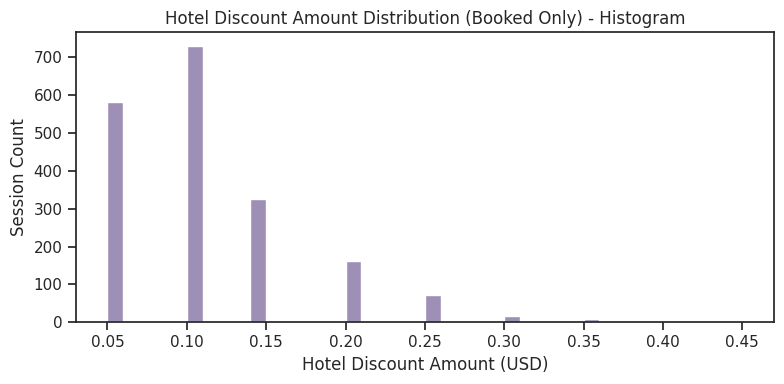

In [0]:
# Filter booked hotels with discount amount
hotel_disc_booked = df_bookings[
    (df_bookings["hotel_booked"]) &
    (df_bookings["hotel_discount_amount"].notnull())
]

plt.figure(figsize=(8,4))

sns.histplot(
    data=hotel_disc_booked,
    x="hotel_discount_amount",
    bins=40,
    kde=False,
    color=travel_palette[1]
)

plt.title("Hotel Discount Amount Distribution (Booked Only) - Histogram")
plt.xlabel("Hotel Discount Amount (USD)")
plt.ylabel("Session Count")
plt.tight_layout()
plt.show()


**Note**: Hotel discounts are tightly clustered around 5-11%, indicating modest reductions are typical in booked sessions.

###### Discount Amount vs Page Clicks - Scatter Plot

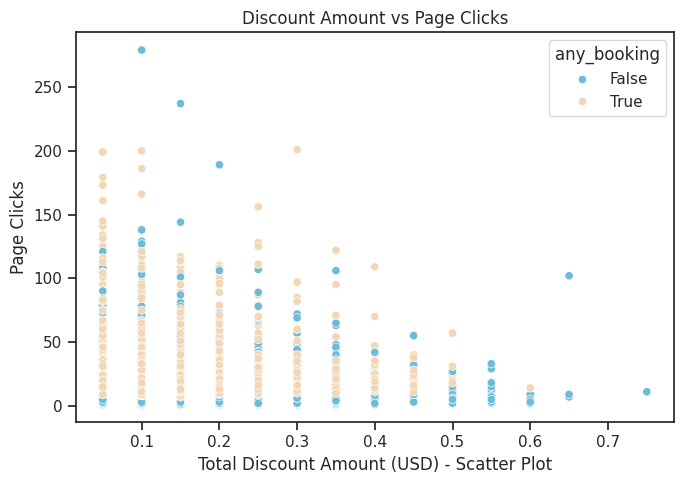

In [0]:
# Prepare combined discount amount column
sl_df_analysis["total_discount_amount"] = (
    sl_df_analysis["flight_discount_amount"].fillna(0) +
    sl_df_analysis["hotel_discount_amount"].fillna(0)
)

df_discount_valid = sl_df_analysis[ 
    (sl_df_analysis["cancellation"] == False) & 
    (sl_df_analysis["total_discount_amount"] > 0) 
]

# Scatter plot: discount vs page clicks
plt.figure(figsize=(7,5))

sns.scatterplot(
    data=df_discount_valid,
    x="total_discount_amount",
    y="page_clicks",
    hue="any_booking",
    palette=[travel_palette[2], travel_palette[5]]
)

#plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("Discount Amount vs Page Clicks")
plt.xlabel("Total Discount Amount (USD) - Scatter Plot")
plt.ylabel("Page Clicks")
plt.tight_layout()
plt.show()


**Note**: **Engagement does not increase with discount size**, users receiving larger discounts tend to click less, not more.

#### 5.6 Correlation Structure of Session-Level Variables

###### Correlation Matrix (numeric features)

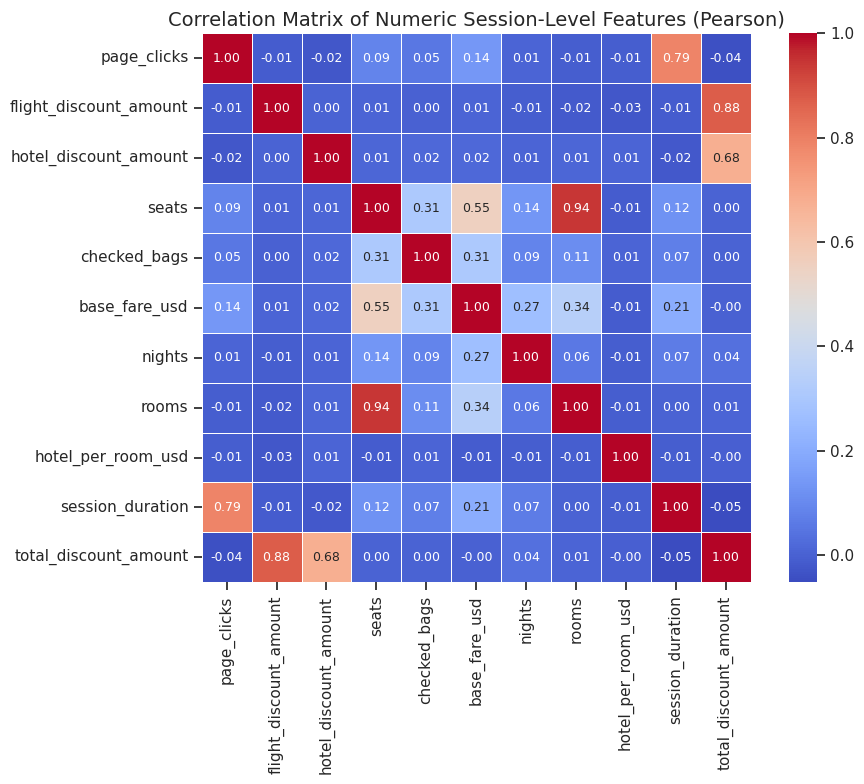

In [0]:
#  Select numeric columns and drop unwanted ones

cols_to_drop = [
    "user_id",
    "home_airport_lat", "home_airport_lon",
    "destination_airport_lat", "destination_airport_lon",
    "session_duration_min", "hour"
]

numeric_df = (
    sl_df_analysis
    .select_dtypes(include="number")
    .drop(columns=cols_to_drop, errors="ignore")
)

# Compute Pearson correlation matrix
corr_matrix = numeric_df.corr(method="pearson")

# Plot heatmap
plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar=True,
    square=True,
    annot_kws={"size": 9}

)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title("Correlation Matrix of Numeric Session-Level Features (Pearson)", fontsize=14)
plt.tight_layout()
plt.show()



**Note**: 
The matrix shows pairwise Pearson correlations between all numeric session-level features.  
Each square is annotated with the correlation coefficient, allowing direct interpretation of linear relationships.

Notable patterns include:

- **Seats vs Rooms**: very strong correlation (0.94), suggesting parallel scaling of flight and hotel capacity, likely reflecting group travel behavior.  
- **Flight Discount vs Total Discount**: strong correlation (0.88), confirming that flight discounts dominate the total.  
- **Hotel Discount vs Total Discount**: moderate correlation (0.68), with hotel discounts contributing less.  
- **Seats vs Base Fare**: moderate correlation (0.55), indicating that fare increases with group size.  
- **Session Duration vs Page Clicks**: strong correlation (0.79), confirming that longer sessions tend to involve more interactions, a consistent engagement pattern across the dataset.

These relationships help validate feature groupings and guide user-level aggregation strategies.  
Highly correlated variables will be consolidated or excluded to avoid redundancy, while stable and interpretable signals will be retained for behavioral modeling.



#### 5.7 Session-Level Insights and Transition to User-Level Analysis

**Session behavior follows a clear and consistent lifecycle, with four mutually exclusive session types:**

- Browsing sessions

- Converted booking sessions

- Unconverted booking sessions

- Cancellation sessions  
Browsing dominates overall activity, while booking-related sessions represent a smaller but behaviorally distinct subset.

- **Engagement patterns differ meaningfully across session types.**
Booking sessions show higher median session duration and page clicks, with lower variability, indicating focused and deliberate behavior.
Non-booking sessions are more heterogeneous, with greater dispersion and more extreme outliers.

- **Booking events are sparse at the session level.**
Only a minority of sessions result in a booking, and cancellations are relatively rare.
Flight-only bookings exhibit the highest cancellation rate, while hotel-only and combined hotel + flight bookings are substantially more stable.

- **Temporal effects are primarily volume-driven rather than behavior-driven.**
Session volume peaks in the early evening, while booking rates remain relatively stable across weekdays and hours, limiting the usefulness of time-based features for segmentation.

- **Price and discount signals are present but sparse and noisy at the session level.**
Discounts are infrequent and generally small, and higher discount amounts are not associated with higher engagement.
This suggests that price sensitivity must be evaluated through aggregated user behavior, not individual sessions.

- **Extensive data quality and lifecycle consistency checks confirm strong internal coherence** across sessions, trips, flights, and hotels.
All identified anomalies (notably hotel stay inconsistencies) were either corrected using reliable temporal references or removed without affecting user-level coverage or trip integrity.

- **Session-level data therefore provides a reliable foundation for user-level aggregation.**
The resulting **user-level dataset**, built by aggregating session activity, bookings, cancellations, engagement, spending, and travel behavior, represents a clean and behaviorally meaningful baseline.

In Notebook 04, this user-level table will be:

- explored through targeted user-level EDA
- enriched with higher-level behavioral features (RFM, CLTV, engagement and price sensitivity metrics)
- finalized as the input dataset for segmentation in Notebook 05

### 6. User-Level Dataset

In [0]:
# Function to compute the Haversine distance between two points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [0]:
# Copy the cleaned session-level dataset 
user_df = sl_df_analysis.copy()

In [0]:
# Flight days away.  
# Ensure datetime
for c in ["departure_time", "return_time"]:
    user_df[c] = pd.to_datetime(user_df[c], errors="coerce")

# Work at date level (ignore hours)
dep_date = user_df["departure_time"].dt.normalize()
ret_date = user_df["return_time"].dt.normalize()

# Base difference (can be NaN)
diff_days = (ret_date - dep_date).dt.days

# Start with NaN
user_df["trip_duration_days"] = np.nan

# Case 1: departure AND return --> inclusive duration
mask_round = dep_date.notna() & ret_date.notna()
user_df.loc[mask_round, "trip_duration_days"] = diff_days[mask_round] + 1

# Case 2: departure but NO return --> 0
mask_oneway = dep_date.notna() & ret_date.isna()
user_df.loc[mask_oneway, "trip_duration_days"] = 0

# Case 3: only hotels (no flights) --> remains NaN
# Guardrail: negative durations → NaN
user_df.loc[user_df["trip_duration_days"] < 0, "trip_duration_days"] = np.nan


In [0]:
# Booking masks
# ------------------------------------------------------------
booking_mask = (
    user_df["trip_id"].notna() &                     # trip exists -> not a browsing session
    (user_df["cancellation"] == False) &             # exclude cancellation sessions
    (user_df["flight_booked"] | user_df["hotel_booked"])  # at least one product booked
)

flight_booking_mask = booking_mask & (user_df["flight_booked"] == True)
hotel_booking_mask  = booking_mask & (user_df["hotel_booked"] == True)


# Revenue calculations
# ------------------------------------------------------------
user_df["flight_revenue"] = user_df["base_fare_usd"].fillna(0) # money spent on flights
user_df["hotel_revenue"] = (
    user_df["hotel_per_room_usd"] * user_df["nights"] * user_df["rooms"]
).fillna(0) # money spent on hotels

user_df["total_revenue_session"] = (
    user_df["flight_revenue"] + user_df["hotel_revenue"] # total spend per session
)

# Session duration
# ------------------------------------------------------------
user_df["session_duration_min"] = (
    (user_df["session_end"] - user_df["session_start"]).dt.total_seconds() / 60
)   # duration of each session in minutes


# Distance
# ------------------------------------------------------------
mask = user_df["destination_airport_lat"].notna()

user_df.loc[mask, "distance_km"] = haversine(
    user_df.loc[mask, "home_airport_lat"],
    user_df.loc[mask, "home_airport_lon"],
    user_df.loc[mask, "destination_airport_lat"],
    user_df.loc[mask, "destination_airport_lon"]
)

user_df["is_booking"] = booking_mask.astype(int) 
user_df["is_flight_booking"] = flight_booking_mask.astype(int) 
user_df["is_hotel_booking"] = hotel_booking_mask.astype(int)

# User-Level Aggregation
# ------------------------------------------------------------
user_agg = user_df.groupby("user_id").agg(

    # --- Timeline metrics ---
    first_session_date = ("session_start", "min"),  # user's first recorded session
    last_session_date = ("session_start", "max"),  # user's most recent session

    # --- Session counts  ---
    n_sessions = ("session_id", "count"), # total number of sessions

    # --- Booking counts ---
    n_flight_bookings = ("is_flight_booking", "sum"), # total number of flight booking sessions
    n_hotel_bookings = ("is_hotel_booking", "sum"), # total number of hotel booking sessions
    n_booking_sessions = ("is_booking", "sum"), # total number of booking sessions, cancellation = False
    n_trip_sessions = ("trip_id", lambda x: x.notna().sum()), # total number of trip sessions(cancellation + booking)
    cancelled_trips = ("cancellation", "sum"), # total number of cancelled trips

    # --- Spend metrics ---
    total_flight_spend = ("flight_revenue", "sum"), # total money spent on flights
    total_hotel_spend = ("hotel_revenue", "sum"),  # total money spent on hotels
    total_spend = ("total_revenue_session", "sum"), # total spend overall

    # --- Session behavior ---
    avg_session_duration = ("session_duration_min", "mean"), # avg session length minutes
    avg_page_clicks  = ("page_clicks", "mean"), # avg clicks per session

    # --- Travel behavior ---
    avg_distance_km = ("distance_km", "mean"), # avg distance traveled
    max_distance_km = ("distance_km", "max"), # longest trip distance
    avg_nights = ("nights", "mean"), # avg hotel nights per stay
    max_nights = ("nights", "max"), # longest hotel stay
    avg_seats  = ("seats", "mean"), # avg seats booked (travel party size)
    avg_rooms  = ("rooms", "mean"), # avg hotel rooms booked
    avg_checked_bags = ("checked_bags", "mean"), # avg number of checked bags
    avg_trip_duration_days = ("trip_duration_days", "mean"), # avg trip duration in days
    max_trip_duration_days = ("trip_duration_days", "max") # longest trip duration in days
   
).reset_index()

# Last booking date
# ------------------------------------------------------------
last_booking = (
    user_df[booking_mask]
    .groupby("user_id")["session_start"]
    .max()
    .reset_index()
    .rename(columns = {"session_start": "last_booking_date"}) # last time user booked
)

user_agg = user_agg.merge(last_booking, on="user_id", how="left")

# Tenure
# ------------------------------------------------------------
user_agg["tenure_days"] = (
    user_agg["last_session_date"] - user_agg["first_session_date"]
).dt.days   # number of days active on the platform

# Rates
# ------------------------------------------------------------
user_agg["booking_rate"] = (
    user_agg["n_booking_sessions"] / user_agg["n_sessions"]
) # share of sessions that resulted in a booking


user_agg["cancellation_rate"] = (
    user_agg["cancelled_trips"] / user_agg["n_booking_sessions"]
).fillna(0) # share of trips that were cancelled

user_agg["conversion_rate"] = (1 - user_agg["cancellation_rate"]
).fillna(0) # share of trips that were completed

# User demographics
# ------------------------------------------------------------
user_demo = user_df[[ 
    "user_id", "gender", "married", "birthdate", "has_children", 
    "home_country", "home_city", "home_airport", "sign_up_date" 
]].drop_duplicates("user_id")

user_level = user_agg.merge(user_demo, on="user_id", how="left")

# Final Cleanup
# -----------------------------------------------------------
final_cols = [
    "user_id",                # unique user identifier
    "gender",                 # user gender
    "married",                # marital status
    "birthdate",              # date of birth
    "has_children",           # whether user has children
    "home_country",           # user's home country
    "home_city",              # user's home city
    "home_airport",           # user's home airport
    "sign_up_date",           # date user joined the platform

    "first_session_date",     # first recorded session
    "last_session_date",      # most recent session
    "last_booking_date",      # most recent booking
    "tenure_days",            # days active on the platform

    "n_sessions",             # total sessions
    "n_booking_sessions",     # total booking sessions, cancellation = False
    "n_trip_sessions",        # total trip sessions (booking sessions + cancellation sessions)
    "total_flight_spend",     # total spend on flights
    "total_hotel_spend",      # total spend on hotels
    "total_spend",            # total spend overall
    "cancelled_trips",        # number of cancelled booked trips (trip-level cancellations)


    "booking_rate",           # % of sessions that result in a booking
    "cancellation_rate",      # % of trips that were cancelled
    "conversion_rate",        # % of booking sessions never cancelled

    "avg_session_duration",   # average session duration (minutes)
    "avg_page_clicks",        # average number of clicks per session

    "avg_distance_km",        # average distance traveled
    "max_distance_km",        # longest distance traveled

    "avg_nights",             # average hotel nights
    "max_nights",             # longest hotel stay
    "avg_seats",              # average seats booked (travel party size)
    "avg_rooms",              # average hotel rooms booked
    "avg_checked_bags",       # average checked bags
    "avg_trip_duration_days", # average trip duration (days)
    "max_trip_duration_days"  # longest trip duration
]

user_level = user_level[final_cols]

print("User-level table created.")
user_level.head()


User-level table created.


,user_id,gender,married,birthdate,has_children,home_country,home_city,home_airport,sign_up_date,first_session_date,last_session_date,last_booking_date,tenure_days,n_sessions,n_booking_sessions,n_trip_sessions,total_flight_spend,total_hotel_spend,total_spend,cancelled_trips,booking_rate,cancellation_rate,conversion_rate,avg_session_duration,avg_page_clicks,avg_distance_km,max_distance_km,avg_nights,max_nights,avg_seats,avg_rooms,avg_checked_bags,avg_trip_duration_days,max_trip_duration_days
0,23557,F,True,1958-12-08,False,usa,new york,LGA,2021-07-22,2023-01-04 19:30:00,2023-07-14 12:36:00,2023-07-14 12:36:00,190,8,2,2,0.00,3802.0,3802.00,0,0.250,0.0,1.0,1.277083,10.250,NaN,NaN,10.0,18.0,NaN,1.5,NaN,NaN,NaN
1,94883,F,True,1972-03-16,False,usa,kansas city,MCI,2022-02-07,2023-01-10 12:20:00,2023-05-28 17:28:00,2023-04-10 21:13:00,138,8,2,2,864.09,230.0,1094.09,0,0.250,0.0,1.0,1.129167,9.125,1453.666128,1536.436758,1.0,1.0,1.5,1.5,0.5,2.5,3.0
2,101486,F,True,1972-12-07,True,usa,tacoma,TCM,2022-02-17,2023-01-21 08:02:00,2023-07-18 09:35:00,2023-06-17 19:42:00,178,8,2,2,189.91,2452.0,2641.91,0,0.250,0.0,1.0,2.037500,16.375,965.340568,965.340568,4.5,5.0,1.0,1.5,0.0,5.0,5.0
3,101961,F,True,1980-09-14,False,usa,boston,BOS,2022-02-17,2023-01-19 03:38:00,2023-06-22 13:27:00,2023-06-22 13:27:00,154,8,5,5,1242.66,2798.0,4040.66,0,0.625,0.0,1.0,1.962500,15.750,1321.684183,4003.264513,4.4,8.0,1.0,1.0,0.4,5.8,9.0
4,106907,F,True,1978-11-17,True,usa,miami,TNT,2022-02-24,2023-01-10 17:24:00,2023-07-27 09:43:48,2023-06-06 09:41:00,197,8,1,2,27804.12,8514.0,36318.12,1,0.125,1.0,0.0,12.648584,30.000,13402.323077,13402.323077,11.0,11.0,6.0,3.0,5.0,14.0,14.0


**Note**: The User-Level base dataset is consistent and ready to be saved into csv file. 

###### Save the User-Level Dataset

In [0]:
# Save user-level dataset (overwrite allowed) 
output_path = "../data/intermediate/user_level.csv" 
user_level.to_csv(output_path, index=False) 
print(f"User-level dataset saved successfully to: {output_path}")

User-level dataset saved successfully to: ../data/intermediate/user_level.csv


**Note**:  
The user-level dataset has been exported in CSV format for use in Notebook 04.